<a href="https://colab.research.google.com/github/luyannn/MH4510-Data-Mining-Project/blob/main/Final_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

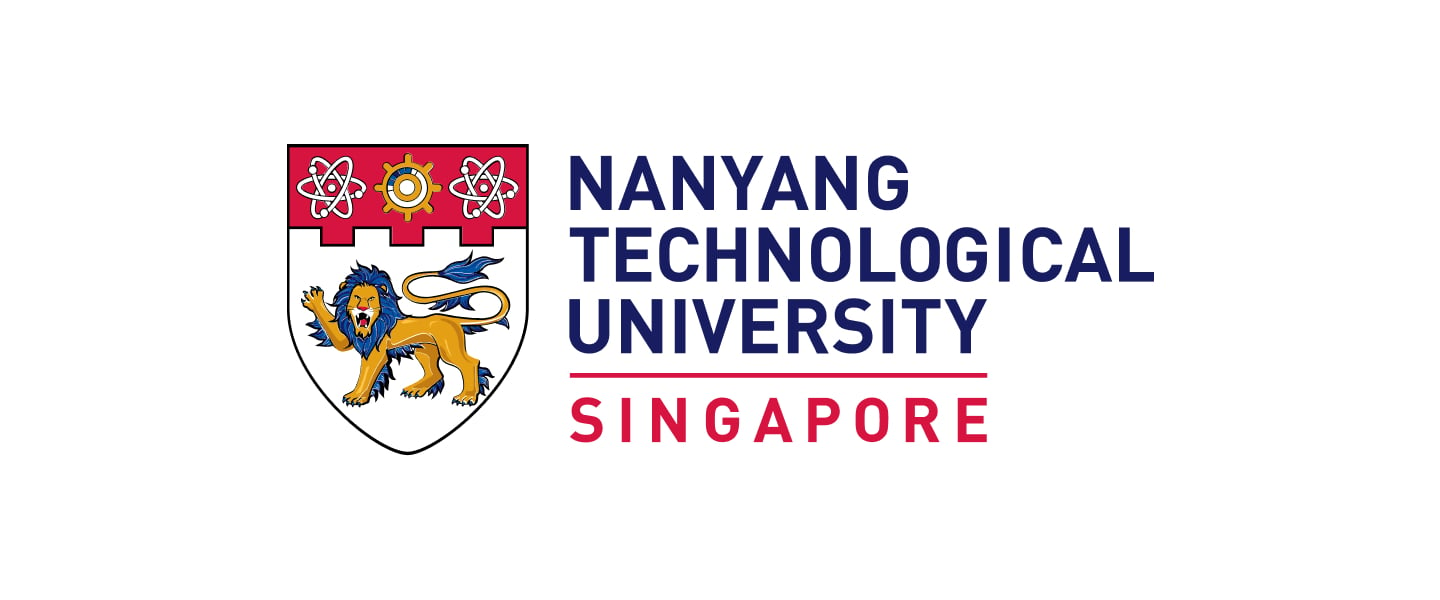

# <div style="text-align: center;">**PREDICTING LUNG CANCER OUTCOMES: LEVERAGING MACHINE LEARNING TECHNIQUES FOR EARLY DETECTION AND PROGNOSIS**</div>

### MH4510: Statistical Learning and Data Mining

### Author: Ian Oon (N2401547J), Tan Lu Yan (U2240431J), Poon Hiu Ching (N2400987E), Sean Gastinov Soeandi (U2220491L), and Ho Inn Jong Jereme (U1940727B)

### Team: Sunset Coral

### 22 November 2024

# Abstract

Lung cancer is a leading cause of cancer-related mortality, emphasizing the need for early detection. This project applies machine learning to predict lung cancer risk using patient survey data, classifying outcomes into binary risk categories while prioritizing the reduction of false negatives. The model provides actionable insights to healthcare professionals, enabling early intervention without formal screening and empowering patients to seek care proactively. We compare several machine learning models: gradient boosting, deep forest, logistic regression, artificial neural networks, and stacking methods to identify the most effective model for deployment.

# 1.0 Introduction

Lung cancer is a leading cause of cancer-related mortality worldwide, responsible for 1.8 million deaths worldwide in 2020 [1]. Early detection is critical in improving survival rates, as it enables timely interventions and better treatment outcomes [2]. This project aims to develop a machine learning model that predicts lung cancer risk using survey data, helping identify individuals at high risk.

With a model achieving 90% accuracy, it is estimated that early detection could prevent up to 1.2 million deaths annually by enabling earlier intervention. This approach does not require any formal screening, allowing patients to assess their risk through a simple survey before seeing a doctor, empowering proactive care and early detection while providing doctors with initial awareness of potential cases.

# Loading Libraries


In [ ]:
install.packages(c("GGally", "caret", "glmnet", "ranger"
                  , "rpart.plot",  "MLmetrics", "PRROC", "ggstats", "foreach", "h2o", "xgboost", "JOUSBoost","smotefamily","keras3"
                  ,"tensorflow","tfruns, reticulate", "TDA","reshape2", "ROSE","caretEnsemble", "gridExtra")
                  , dependencies = TRUE)

In [ ]:
system("sudo apt get googledrive")
library(googledrive)
drive_auth(use_oob = TRUE, cache = FALSE )
file_id <- "1a4pJTFiPTIQGRpDv5uJJWp-WDBJKJsxZ"
drive_download(as_id(file_id), path = "survey lung cancer.csv", overwrite = TRUE)


In [ ]:
# CATBOOST NOT ON CRAN, INSTALL HERE:
install.packages('remotes')
remotes::install_url('https://github.com/catboost/catboost/releases/download/v1.2.7/catboost-R-darwin-universal2-1.2.7.tgz', INSTALL_opts = c("--no-multiarch", "--no-test-load"))

In [ ]:
library(ggplot2)
library(dplyr)
library(GGally)
library(caret)
library(glmnet)
library(tidyr)
library(rpart)
library(rpart.plot)
library(ranger)
library(MLmetrics)
library(PRROC)
library(gridExtra)
library(tensorflow)
library(tfruns)
library(smotefamily)
library(reticulate)
library(keras3)
library(xgboost)
library(JOUSBoost)
library(ROSE)
library(catboost)
library(reshape2)
library(TDA)


# 2.0 Data Preparation

## 2.1 Dataset Description

This dataset focuses on various health-related factors associated with lung cancer. It comprises of fifteen features that capture lifestyle choices and medical symptoms. It includes attributes such as age, gender, smoking status, as well as indicators of chronic disease such as anxiety, fatigue, and respiratory issues. The dataset was selected for its relevance to lung cancer research and is widely recognized on Kaggle. It is also the most downloaded and utilized for related projects. Its comprehensive nature provides an excellent resource for exploring correlations between lifestyle factors and lung cancer, yielding insights that can inform public health strategies and preventive measures.

| Feature                   | Description                             |
|---------------------------|-----------------------------------------|
| GENDER                    | 1: Male, 0: Female                      |
| AGE                       | Age of the individual (in years)       |
| SMOKING                   | 1: Smoker, 0: Non-smoker                |
| YELLOW_FINGERS            | 1: Yes (yellow fingers), 0: No         |
| ANXIETY                   | 1: Yes, 0: No (anxiety symptoms)       |
| PEER_PRESSURE             | 1: Yes, 0: No (influence from peers)   |
| CHRONIC.DISEASE           | 1: Yes, 0: No (chronic health issues)  |
| FATIGUE                   | 1: Yes, 0: No (feeling tired)          |
| ALLERGY                   | 1: Yes, 0: No (presence of allergies)  |
| WHEEZING                  | 1: Yes, 0: No (wheezing sound)         |
| ALCOHOL.CONSUMING         | 1: Yes, 0: No (alcohol consumption)    |
| COUGHING                  | 1: Yes, 0: No (coughing symptoms)      |
| SHORTNESS.OF.BREATH       | 1: Yes, 0: No (difficulty breathing)    |
| SWALLOWING.DIFFICULTY     | 1: Yes, 0: No (difficulty swallowing)   |
| CHEST.PAIN                | 1: Yes, 0: No (chest pain)             |
| LUNG_CANCER               | 1: Yes, 0: No (lung cancer diagnosis)   |


## 2.2 Data Cleaning

Rows with missing values were removed to prevent skewing of results. The dataset was filtered to include only individuals aged 55 and older, as this demographic is more susceptible to lung cancer. Categorical variables, like gender and smoking status, were converted into binary factors. Duplicate rows were retained, as identical responses from individuals of the same age and gender are valid within the context of a YES/NO survey.

Outliers were identified using boxplots generated by `ggplot`. The removal of the outlier whose age is 87 is justified as it represented only a single data point in that age range. This would make predictions for that age range unreliable compared to other age groups with more substantial data representation. Additionally, the distribution of lung cancer diagnoses was assessed, highlighting a notable imbalance. A higher count of positive cases than negatives cases will be addressed in the following models.

[1] "Percentage of Records with Lung Cancer: 86.99 %"

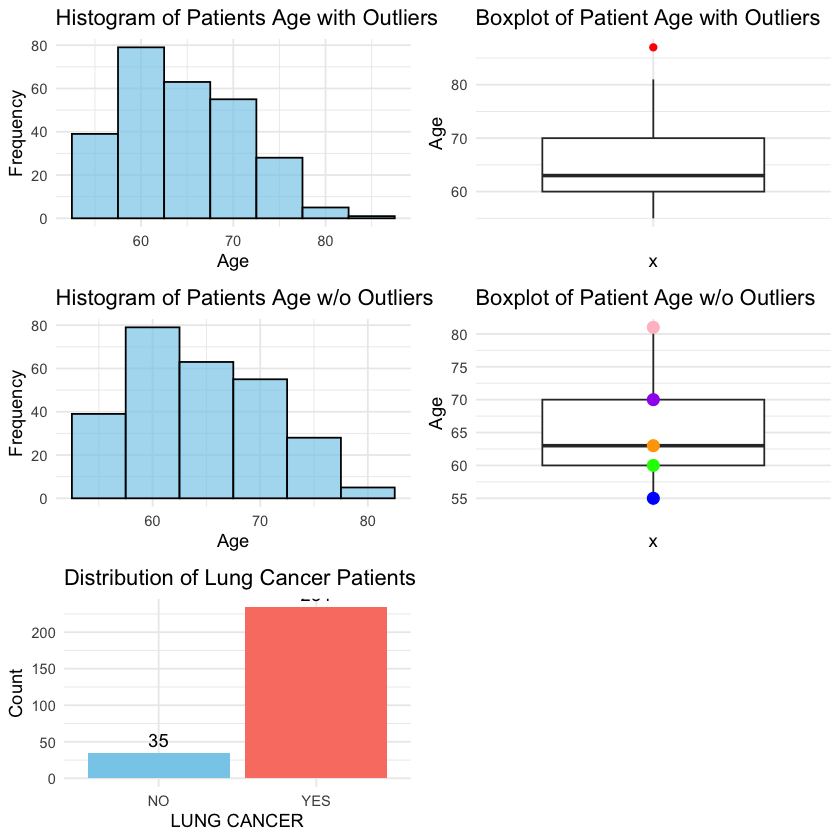

In [ ]:
#@title Cleaning of data

options(warn = -1)
variable_name <- ""
lung_cancer <- read.csv("survey lung cancer.csv", header = TRUE)
# Remove rows with any missing values
lung_cancer <- na.omit(lung_cancer)

# Remove AGE < 55, since considering senior citizens only, prone to lung cancer
lung_cancer <- lung_cancer %>%
  filter(AGE >= 55)

# Convert binary variables to factors; YES = 2 & NO = 1, but LUNG_CANCER still YES/NO factor
lung_cancer <- lung_cancer %>%
  mutate(across(c("GENDER", "SMOKING", "YELLOW_FINGERS", "ANXIETY",
                  "PEER_PRESSURE", "CHRONIC.DISEASE", "FATIGUE",
                  "ALLERGY", "WHEEZING", "ALCOHOL.CONSUMING",
                  "COUGHING", "SHORTNESS.OF.BREATH",
                  "SWALLOWING.DIFFICULTY", "CHEST.PAIN", "LUNG_CANCER"),
                 factor))

# Check for outliers in boxplot & histogram
boxplot_before <-ggplot(lung_cancer, aes(x = "", y = AGE)) +
  geom_boxplot(outlier.colour = "red", outlier.shape = 16, outlier.size = 2) +
  labs(title = "Boxplot of Patient Age with Outliers", y = "Age") +
  theme_minimal()
histogram_before <- ggplot(lung_cancer, aes(x = AGE)) +
  geom_histogram(binwidth = 5, fill = "skyblue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of Patients Age with Outliers", x = "Age", y = "Frequency") +
  theme_minimal()
# Remove the outlier
lung_cancer <- lung_cancer %>%
  filter(AGE != max(lung_cancer$AGE))

# Check outlier removed in boxplot & histogram
boxplot_after <- ggplot(lung_cancer, aes(x = "", y = AGE)) +
  geom_boxplot(outlier.colour = "red", outlier.shape = 16, outlier.size = 2) +
  stat_summary(fun = min, geom = "point", color = "blue", size = 3, shape = 19) +
  stat_summary(fun = function(x) quantile(x, 0.25), geom = "point", color = "green", size = 3, shape = 19) +
  stat_summary(fun = median, geom = "point", color = "orange", size = 3, shape = 19) +
  stat_summary(fun = function(x) quantile(x, 0.75), geom = "point", color = "purple", size = 3, shape = 19) +
  stat_summary(fun = max, geom = "point", color = "pink", size = 3, shape = 19) +
  labs(title = "Boxplot of Patient Age w/o Outliers", y = "Age") +
  theme_minimal()
histogram_after <- ggplot(lung_cancer, aes(x = AGE)) +
  geom_histogram(binwidth = 5, fill = "skyblue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of Patients Age w/o Outliers", x = "Age", y = "Frequency") +
  theme_minimal()


# Create a bar chart for LUNG_CANCER to check imbalanced data
bar_chart <-ggplot(lung_cancer, aes(x = LUNG_CANCER)) +
  geom_bar(fill = c("skyblue", "salmon")) + # Choose colors for the bars
  labs(title = "Distribution of Lung Cancer Patients",
       x = "LUNG CANCER",
       y = "Count") +
  theme_minimal() +
  geom_text(stat='count', aes(label=..count..), vjust=-0.5) # Add counts above the bars



# Arrange plots with better spacing and larger layout
grid.arrange(
  histogram_before, boxplot_before,
  histogram_after, boxplot_after,
   bar_chart,
  nrow = 3, ncol = 2,
  heights = c(1, 1, 1), widths = c(1, 1)
)

# Calculate the percentage of records with lung cancer
percentage_with_lung_cancer <- sum(lung_cancer$LUNG_CANCER == "YES") / nrow(lung_cancer) * 100
paste("Percentage of Records with Lung Cancer:", round(percentage_with_lung_cancer, 2), "%")


# 3.0 Exploratory Data Analysis

## 3.1 Stacked Bar Chart

The stacked bar chart reveals a significant data imbalance, with 86.99% of records indicating positive lung cancer cases (234 “YES” cases) and only 13% negative cases (35 “NO” cases). Due to the imbalanced dataset, there is a tendency to predict 'YES' more frequently. Therefore, models using the balanced accuracy metric are selected to address this imbalance.

Males have a higher incidence of lung cancer than females, especially in the 60-65 age range, which had the highest number of diagnoses, followed by the 55-60 range. The 65-70 and 70-75 age groups showed similar rates, with females slightly outnumbering males in the 70-75 group. The 80-85 age group had no diagnoses among males. Alcohol consumption, allergies, and anxiety are leading factors associated with lung cancer in both genders.

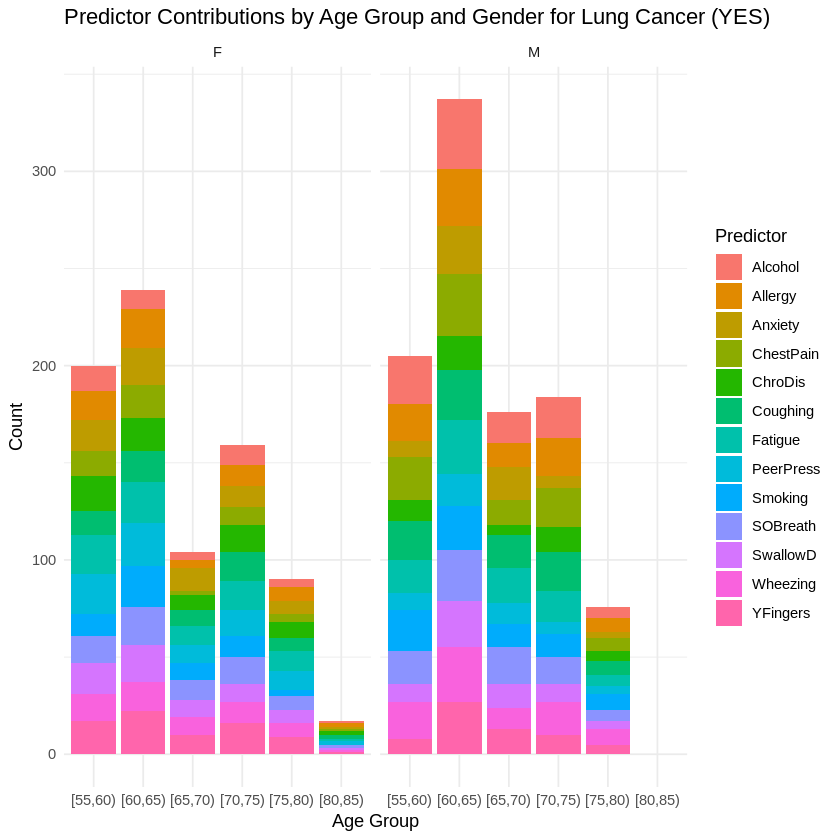

In [ ]:
# @title Code to display bar chart
# Rename columns to shorter versions (max 13 letters)
lung_cancer_EDA <- lung_cancer %>%
  rename(
    Gender = GENDER,
    Age = AGE,
    Smoking = SMOKING,
    YFingers = YELLOW_FINGERS,
    Anxiety = ANXIETY,
    PeerPress = PEER_PRESSURE,
    ChroDis = CHRONIC.DISEASE,
    Fatigue = FATIGUE,
    Allergy = ALLERGY,
    Wheezing = WHEEZING,
    Alcohol = ALCOHOL.CONSUMING,
    Coughing = COUGHING,
    SOBreath = SHORTNESS.OF.BREATH,
    SwallowD = SWALLOWING.DIFFICULTY,
    ChestPain = CHEST.PAIN,
    LungCnc = LUNG_CANCER
  )

# Create age ranges
lung_cancer_EDA <- lung_cancer_EDA %>%
  mutate(AgeGroup = cut(Age, breaks = seq(55, 85, by = 5), right = FALSE))

# Convert relevant variables to factors for plotting
lung_cancer_EDA$LungCnc <- factor(lung_cancer_EDA$LungCnc, levels = c("NO", "YES"))
lung_cancer_EDA$Gender <- factor(lung_cancer_EDA$Gender, levels = c("F", "M"))

# Create a summary table for each predictor
# We will reshape the data for stacking
predictors <- c("Smoking", "YFingers", "Anxiety", "PeerPress", "ChroDis",
                "Fatigue", "Allergy", "Wheezing", "Alcohol", "Coughing",
                "SOBreath", "SwallowD", "ChestPain")

# Filter for Lung Cancer "YES" and reshape data
long_data <- lung_cancer_EDA %>%
  filter(LungCnc == "YES") %>%
  select(AgeGroup, Gender, LungCnc, all_of(predictors)) %>%
  pivot_longer(cols = all_of(predictors), names_to = "Predictor", values_to = "Response") %>%
  filter(Response == "2") %>%  # Assuming '2' indicates a positive response
  group_by(AgeGroup, Gender, Predictor) %>%
  summarize(Count = n(), .groups = 'drop')

# Combine the counts for the plot
plot_data <- long_data %>%
  group_by(AgeGroup, Gender) %>%
  summarize(TotalCount = sum(Count), .groups = 'drop') %>%
  left_join(long_data, by = c("AgeGroup", "Gender")) %>%
  replace_na(list(Count = 0))

# Plotting the stacked bar chart
ggplot(plot_data, aes(x = AgeGroup, y = Count, fill = Predictor)) +
  geom_bar(stat = "identity", position = "stack") +
  facet_wrap(~ Gender) +
  labs(title = "Predictor Contributions by Age Group and Gender for Lung Cancer (YES)",
       x = "Age Group",
       y = "Count",
       fill = "Predictor") +
  theme_minimal()

## 3.2 Contingency Table

The contingency table for lung cancer incidence reveals a slight gender disparity, with 105 female and 129 male cases among the affected population. However, our primary focus is on the binary outcomes of lung cancer diagnosis, which indicates that while gender differences exist, they do not significantly alter the overall prevalence of the disease.

In [ ]:
# @title Code for contingency table
# Contingency table to show count of YES/NO lung cancer for each male/female
lung_cancer_contigency_table <- table(lung_cancer_EDA$Gender, lung_cancer_EDA$LungCnc)
print("Lung Cancer Contingency Table:")
lung_cancer_contigency_table

## 3.3 Pearson's Correlation Heatmap

Based on the Pearson's correlation heatmap, multicollinearity is minimal, with no significant issues for model building. The threshold for moderate and high correlation was set at 0.6 and 0.8, respectively. The highest correlation observed was between Yellow Fingers and Anxiety, with $r = 0.56$.

No highly correlated predictor pairs found above the threshold.


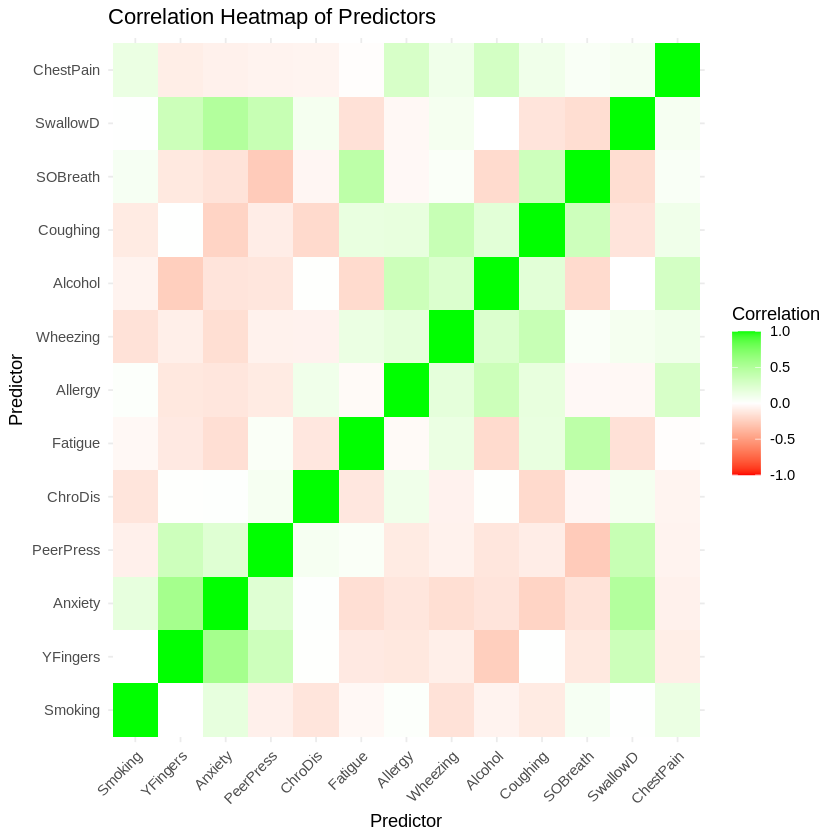

In [ ]:
# @title Code for correlation matrix and heatmap

library(reshape2)
# Convert categorical variables to numeric for analysis
lung_cancer_numeric <- lung_cancer_EDA %>%
  mutate(
    # Convert Gender: "M" to 1 and "F" to 2
    Gender = as.numeric(factor(Gender, levels = c("M", "F"), labels = c(1, 2))),

    # Convert LungCnc: "NO" to 0 and "YES" to 1
    LungCnc = as.numeric(factor(LungCnc, levels = c("NO", "YES"), labels = c(0, 1))),

    # Convert any other factors to numeric
    across(where(is.factor), ~ as.numeric(as.character(.)))
  )

# Convert selected predictors back to factors for analysis
lung_cancer_numeric <- lung_cancer_numeric %>%
  mutate(across(all_of(predictors), as.factor),
         LungCnc = as.factor(LungCnc))

# Compute the correlation matrix for the predictors
lung_cancer_cor <- lung_cancer_numeric %>%
  select(all_of(predictors)) %>%
  mutate(across(everything(), as.numeric)) %>%
  cor(method = "pearson")

# Melt the correlation matrix for visualization
lung_cancer_cor_melted <- melt(lung_cancer_cor)

# Create a heatmap of the correlation matrix
ggplot(data = lung_cancer_cor_melted, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile() +
  scale_fill_gradient2(low = "red", high = "green", mid = "white",
                       midpoint = 0, limit = c(-1, 1), space = "Lab",
                       name = "Correlation") +
  theme_minimal() +
  labs(title = "Correlation Heatmap of Predictors",
       x = "Predictor",
       y = "Predictor") +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

# Define a threshold for identifying high correlations
high_corr_threshold <- 0.8

# Identify pairs of highly correlated predictors
highly_correlated <- which(abs(lung_cancer_cor) > high_corr_threshold &
                           lower.tri(lung_cancer_cor), arr.ind = TRUE)

# Print highly correlated predictors if any are found (vectorized without for loop)
if (nrow(highly_correlated) > 0) {
  cat("Highly correlated predictors (threshold > 0.8):\n")
  apply(highly_correlated, 1, function(row) {
    cat(paste0("- ", rownames(lung_cancer_cor)[row["row"]],
               " and ",
               colnames(lung_cancer_cor)[row["col"]],
               " with correlation: ",
               round(lung_cancer_cor[row["row"], row["col"]], 2), "\n"))
  })
} else {
  cat("No highly correlated predictor pairs found above the threshold.\n")
}


## 3.4 Chi Squared Test



We performed a chi-square test of independence for all unique pairs of predictor variables in the dataset to assess their associations. The goal is to identify non-significant pairs (p-value > 0.05) and determine if any predictors can be removed due to having no significant relationships.

In [ ]:
# @title chi sqaure code
# List of predictor variables, matching the exact column names
predictors <- c("Smoking", "YFingers", "Anxiety", "PeerPress",
                "ChroDis", "Fatigue", "Allergy", "Wheezing",
                "Alcohol", "Coughing", "SOBreath", "SwallowD", "ChestPain")

# Check if all predictor columns are in the dataset
missing_predictors <- predictors[!predictors %in% colnames(lung_cancer_EDA)]
if (length(missing_predictors) > 0) {
  stop("The following predictors are missing in the dataset: ", paste(missing_predictors, collapse = ", "))
}

# Function to compute the chi-square p-value for two variables
compute_chi_square_p_value <- function(var1, var2, data) {
  contingency_table <- table(data[[var1]], data[[var2]])

  # Skip if the table is empty
  if (sum(contingency_table) == 0) {
    return(NA)
  }

  # Perform chi-square test if expected frequencies are sufficient
  if (all(chisq.test(contingency_table, simulate.p.value = FALSE)$expected >= 5)) {
    return(chisq.test(contingency_table)$p.value)
  } else {
    return(NA)
  }
}

# Generate all unique pairs of predictors
pairs <- combn(predictors, 2, simplify = FALSE)

# Compute p-values for each pair
p_values <- sapply(pairs, function(pair) {
  compute_chi_square_p_value(pair[1], pair[2], lung_cancer_EDA)
})

# Create a data frame of pairs and their p-values
chi_square_results <- data.frame(
  Predictor1 = sapply(pairs, `[`, 1),
  Predictor2 = sapply(pairs, `[`, 2),
  P_Value = p_values
)

# Filter non-significant pairs (p-value > threshold)
non_significant_threshold <- 0.05
non_significant_pairs <- chi_square_results %>%
  filter(P_Value > non_significant_threshold | is.na(P_Value))

# Identify variables with only non-significant associations
non_significant_predictors <- unique(c(
  non_significant_pairs$Predictor1,
  non_significant_pairs$Predictor2
))

removable_predictors <- non_significant_predictors[
  !non_significant_predictors %in% unique(c(chi_square_results$Predictor1[chi_square_results$P_Value <= non_significant_threshold],
                                            chi_square_results$Predictor2[chi_square_results$P_Value <= non_significant_threshold]))
]

# Display whether any predictors can be removed
if (length(removable_predictors) > 0) {
  cat("Predictors that can potentially be removed due to non-significant associations.\n")
} else {
  cat("No predictors can be removed based on non-significant associations.\n")
}


No predictors can be removed based on non-significant associations.


No predictors can be removed, indicating all predictors contribute some meaningful information to the dataset.

## 3.5 Summary of Statistics

Sections 3.1-3.4 can be summarised as follows.

| Statistic                             | Value                                       |
|---------------------------------------|---------------------------------------------|
| Total Cases                           | 269                                         |
| Positive Cases ("YES")                | 234 (86.99%)                                |
| Negative Cases ("NO")                 | 35 (13.01%)                                 |
| Male Cases                            | 129                                         |
| Female Cases                          | 105                                         |
| Age Group with Most Diagnoses         | 60-65 years                                 |
| Top Predictors for Lung Cancer        | Alcohol Consumption, Allergies, Anxiety     |
| Highest Pearson Correlation (r)       | Yellow Fingers and Anxiety (r = 0.56)      |
| Chi-Square Significant Associations   | None are significant enough to be removed            |
| Non-Significant Pairs (to Remove)     | Some age-gender combinations, lifestyle factors |

<left><font size="1">Table 1: Summary of sections 3.1-3.4 exploratory data analysis.</left>

# 4.0 Split Training and Test Dataset

The dataset was partitioned into training and testing subsets in a 70-30 ratio for subsequent model building.

In [ ]:
# @title Code for training and test dataset
# Split data before any transformation
set.seed(1547)
# Create indicies & SPLIT
indicies <- runif(nrow(lung_cancer)) <= 0.7
train_data <- lung_cancer %>% filter(indicies)
test_data <- lung_cancer %>% filter(!indicies)

# 5.0 Gradient Boosting Algorithms

## 5.1 Extreme Gradient Boosting (XGBoost)

Extreme Gradient Boosting (XGBoost) is a supervised machine learning algorithm for binary classification and regression tasks. It constructs decision trees sequentially to optimize an objective function, even with small datasets. The model's prediction is given by:

$$
f(x) = \sum_{k=1}^{K} f_k(x_i)
$$

where $k$ is the number of trees. The objective function combines the training loss and regularization term:

$$
\text{Obj}(\theta) = L(\theta) + \Omega(\theta)
$$

The log-loss function is used for binary classification:

$$
L(\theta) = \sum_{i=1}^{N} \left[ y_i \log(1 + e^{-\hat{y}_i}) + (1 - y_i) \log(1 + e^{\hat{y}_i}) \right]
$$

Regularization prevents overfitting:

$$
\Omega(\theta) = \alpha \lambda \sum_{j=1}^{p} |\theta_j| + (1 - \alpha) \lambda \sum_{j=1}^{p} \theta_j^2
$$

Key parameters include `max.depth = 2` and `eta = 1`. The `early_stopping_rounds` parameter (set to 10) terminates training if the log-loss does not improve, and `scale_pos_weight = 0.1495726` addresses class imbalance. These settings eliminated the need for ROSE. The model achieved its best log-loss of 0.1635 at 50 trees.

Performance was evaluated using balanced accuracy, which accounts for sensitivity and specificity:

$$
\text{Balanced Accuracy} = \frac{1}{2} \left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP} \right)
$$

At a threshold of 0.1, the model achieved a training balanced accuracy of 87.82% and a test balanced accuracy of 75.18%, with a 12.64% difference indicating slight overfitting. The training recall was 76.9%, while the test recall was 55.5%, showing a 21.4% gap. Important predictors identified were swallowing difficulty, allergy, and alcohol consumption, aligning with exploratory data analysis.


Scale Pos Weight Parameter for XGBoost =  0.1495726 


[1] "Best Iteration for Log Loss XGBoost Tree: 167 with 0.151997906835292"

Training Recall:  0.7692308 
Test Recall:  0.5555556 
Recall Difference:  0.2136752 


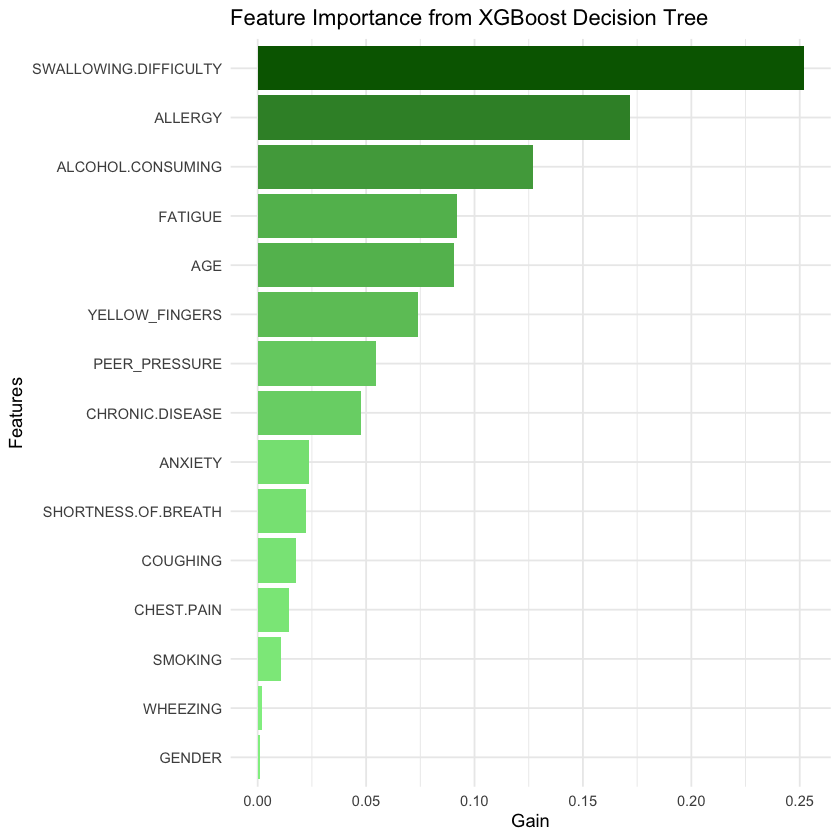

In [ ]:
# @title Code for XGBoost


# Prepare the dataset by recoding to {0, 1}; AGE remains same continuous
lung_cancer_XGBoost <- lung_cancer %>%
  mutate(
    GENDER = ifelse(GENDER == "M", 1, 0),  # GENDER: 1 = Male, 0 = Female
    LUNG_CANCER = ifelse(LUNG_CANCER == "YES", 1, 0),  # LUNG_CANCER: 0 = No, 1 = Yes
    SMOKING = ifelse(SMOKING == 2, 1, 0),        # Convert factor to binary: 1 = Yes, 0 = No
    YELLOW_FINGERS = ifelse(YELLOW_FINGERS == 2, 1, 0),
    ANXIETY = ifelse(ANXIETY == 2, 1, 0),
    PEER_PRESSURE = ifelse(PEER_PRESSURE == 2, 1, 0),
    CHRONIC.DISEASE = ifelse(CHRONIC.DISEASE == 2, 1, 0),
    FATIGUE = ifelse(FATIGUE == 2, 1, 0),
    ALLERGY = ifelse(ALLERGY == 2, 1, 0),
    WHEEZING = ifelse(WHEEZING == 2, 1, 0),
    ALCOHOL.CONSUMING = ifelse(ALCOHOL.CONSUMING == 2, 1, 0),
    COUGHING = ifelse(COUGHING == 2, 1, 0),
    SHORTNESS.OF.BREATH = ifelse(SHORTNESS.OF.BREATH == 2, 1, 0),
    SWALLOWING.DIFFICULTY = ifelse(SWALLOWING.DIFFICULTY == 2, 1, 0),
    CHEST.PAIN = ifelse(CHEST.PAIN == 2, 1, 0)
  )

# Split data before any transformation
set.seed(1547)
# Create indicies & SPLIT
indicies <- runif(nrow(lung_cancer_XGBoost)) <= 0.7
train_data <- lung_cancer_XGBoost %>% filter(indicies)
test_data <- lung_cancer_XGBoost %>% filter(!indicies)


# Train predictors & labels => Convert to matrix
train_predictors <- train_data %>% select(-LUNG_CANCER)
train_predictors <- as.matrix(train_predictors)
train_labels <- train_data %>% select(LUNG_CANCER)
train_labels <- as.matrix(train_labels)

# Test predictors & labels => Convert to matrix
test_predictors <- test_data %>% select(-LUNG_CANCER)
test_predictors <- as.matrix(test_predictors)
test_labels <- test_data %>% select(LUNG_CANCER)
test_labels <- as.matrix(test_labels)

# Get scale_pos_weight ratio for parameter below
scale_pos_weight <- sum(lung_cancer_XGBoost$LUNG_CANCER == 0) / sum(lung_cancer_XGBoost$LUNG_CANCER == 1)
cat("Scale Pos Weight Parameter for XGBoost = ", scale_pos_weight, "\n")

# Simply train XGBoost model with Log-Loss
xgboost_decision_tree_log_loss <- xgboost(data = train_predictors, label = train_labels, max.depth = 2, eta = 1, nround = 500, objective = "binary:logistic", eval_metric = "logloss", early_stopping_rounds = 10, scale_pos_weight = scale_pos_weight, verbose = 0)

# Get feature importance
xg_boost_decision_tree_importance <- xgb.importance(feature_names = colnames(train_predictors), model = xgboost_decision_tree_log_loss)
# Convert importance to data frame
importance_df <- as.data.frame(xg_boost_decision_tree_importance)
# Create the plot with a gradient color
ggplot(importance_df, aes(x = reorder(Feature, Gain), y = Gain, fill = Gain)) +
  geom_bar(stat = "identity") +
  coord_flip() +  # Flips the axes for better readability
  labs(title = "Feature Importance from XGBoost Decision Tree",
       x = "Features",
       y = "Gain") +
  scale_fill_gradient(low = "lightgreen", high = "darkgreen") +  # Customize colors as desired
  theme_minimal() +
  theme(legend.position = "none")  # Optionally hide the legend

# XGBoost metrics
# Make predictions on the training dataset
train_predictions <- predict(xgboost_decision_tree_log_loss, train_predictors)
train_binary_predictions <- ifelse(train_predictions > 0.1, 1, 0)
# Create the confusion matrix for the training set
train_confusion_matrix <- confusionMatrix(factor(train_binary_predictions), factor(train_labels))

# Make predictions on the test dataset
predictions <- predict(xgboost_decision_tree_log_loss, test_predictors)
binary_predictions <- ifelse(predictions > 0.1, 1, 0)
# Create the confusion matrix
confusion_matrix <- confusionMatrix(factor(binary_predictions), factor(test_labels))

# Display Log-Loss Metrics
paste("Best Iteration for Log Loss XGBoost Tree:", xgboost_decision_tree_log_loss$best_iteration, "with", xgboost_decision_tree_log_loss$best_score)

# Extract recall from the confusion matrix for training and test datasets
# For training set confusion matrix
train_recall <- train_confusion_matrix$byClass['Recall']
cat("Training Recall: ", train_recall, "\n")
# For test set confusion matrix
test_recall <- confusion_matrix$byClass['Recall']
cat("Test Recall: ", test_recall, "\n")
# Recall Difference
test_recall <- confusion_matrix$byClass['Recall']
cat("Recall Difference: ", train_recall - test_recall, "\n")

## 5.2 Adaptive Boosting (ADABoost)

Adaptive Boosting (AdaBoost) is a supervised ensemble method that combines weak learners to create a robust model. It adjusts sample weights rather than optimizing a loss function, indirectly influencing feature importance.

Initially, all data points have equal weights:

$$
w(x_i, y_i) = \frac{1}{N}, \quad \text{for } i = 1, 2, \ldots, N
$$

For each feature, decision stumps are created, and the Gini index is calculated:

$$
\text{Gini} = 1 - (p_1^2 + p_2^2)
$$

where $p_1$ and $p_2$ are class probabilities. The stump with the lowest Gini index is selected as the classifier. Its importance is determined by:

$$
\alpha_t = \frac{1}{2} \log\left(\frac{1 - \text{total error}}{\text{total error}}\right)
$$

Weights are updated iteratively:

$$
w_i^{(t+1)} = w_i^{(t)} \cdot e^{\pm \alpha_t}
$$

Correctly classified points have reduced weights, while misclassified points are given higher weights, enabling the model to focus on difficult instances.

Parameters used were `tree_depth = 1` and `nrounds = 100`. Deeper trees and more iterations caused significant overfitting. The absence of `early_stopping_rounds` limited control over stopping criteria.

AdaBoost achieved a training balanced accuracy of 89.11% and a test balanced accuracy of 70.27%, with an 18.84% difference, indicating severe overfitting. Training recall was 97.5%, while test recall was 44.4%, showing a 32.5% difference, highlighting high overfitting likely caused by limited hyperparameter tuning.


In [ ]:
# @title Code for ADABoost


# Prepare the dataset by recoding to {1, -1}; AGE remains the same continuous => All need to be numeric, not factors
lung_cancer_ADABoost <- lung_cancer %>%
  mutate(
    GENDER = ifelse(GENDER == "M", 1, -1),  # GENDER: 1 = Male, -1 = Female
    LUNG_CANCER = ifelse(LUNG_CANCER == "YES", 1, -1),  # LUNG_CANCER: -1 = No, 1 = Yes
    SMOKING = ifelse(SMOKING == 2, 1, -1),        # Convert factor to binary: 1 = Yes, -1 = No
    YELLOW_FINGERS = ifelse(YELLOW_FINGERS == 2, 1, -1),
    ANXIETY = ifelse(ANXIETY == 2, 1, -1),
    PEER_PRESSURE = ifelse(PEER_PRESSURE == 2, 1, -1),
    CHRONIC.DISEASE = ifelse(CHRONIC.DISEASE == 2, 1, -1),
    FATIGUE = ifelse(FATIGUE == 2, 1, -1),
    ALLERGY = ifelse(ALLERGY == 2, 1, -1),
    WHEEZING = ifelse(WHEEZING == 2, 1, -1),
    ALCOHOL.CONSUMING = ifelse(ALCOHOL.CONSUMING == 2, 1, -1),
    COUGHING = ifelse(COUGHING == 2, 1, -1),
    SHORTNESS.OF.BREATH = ifelse(SHORTNESS.OF.BREATH == 2, 1, -1),
    SWALLOWING.DIFFICULTY = ifelse(SWALLOWING.DIFFICULTY == 2, 1, -1),
    CHEST.PAIN = ifelse(CHEST.PAIN == 2, 1, -1)
  )

# Split data before any transformation
set.seed(1547)
# Create indicies & SPLIT
indicies <- runif(nrow(lung_cancer_ADABoost)) <= 0.7
train_data <- lung_cancer_ADABoost %>% filter(indicies)
test_data <- lung_cancer_ADABoost %>% filter(!indicies)
# Train predictors & labels => Convert to matrix
train_predictors <- train_data %>% select(-LUNG_CANCER)
train_predictors <- as.matrix(train_predictors)
train_labels <- train_data$LUNG_CANCER
# Test predictors & labels => Extract from df so as vector
test_predictors <- test_data %>% select(-LUNG_CANCER)
test_predictors <- as.matrix(test_predictors)
test_labels <- test_data$LUNG_CANCER

# Train ADABoost Decision Tree
adaboost_decision_tree <- adaboost(train_predictors, train_labels, tree_depth = 1, n_rounds = 100, verbose = FALSE, control = NULL)
# adaboost_decision_tree$confusion_matrix

# Metrics of AdaBoost Decision Tree
# Extract values from the confusion matrix
TP <- adaboost_decision_tree$confusion_matrix[2, 2]  # True Positives (1 predicted as 1)
TN <- adaboost_decision_tree$confusion_matrix[1, 1]  # True Negatives (-1 predicted as -1)
FP <- adaboost_decision_tree$confusion_matrix[1, 2]  # False Positives (1 predicted as -1)
FN <- adaboost_decision_tree$confusion_matrix[2, 1]  # False Negatives (-1 predicted as 1)
# Calculate Balanced Accuracy
balanced_accuracy <- (TP / (TP + FN) + TN / (TN + FP)) / 2
# Calculate Recall
recall <- TP / (TP + FN)
# Print results
cat("Balanced Accuracy:", balanced_accuracy, "\n")
cat("Train Recall:", recall, "\n")

# Test set predictions & metrics
predictions <- predict(adaboost_decision_tree, test_predictors)  # Specify X explicitly
predicted_labels <- as.factor(ifelse(predictions > 0.1, 1, -1))  # Assuming predictions are scores
confusion_matrix <- confusionMatrix(predicted_labels, as.factor(test_labels))


# For test set confusion matrix
test_recall <- confusion_matrix$byClass['Recall']
cat("Test Recall: ", test_recall, "\n")

Balanced Accuracy: 0.8911073 
Train Recall: 0.9745223 
Test Recall:  0.4444444 


## 5.3 Categorical Boosting (CatBoost)

Categorical Boosting (CatBoost) uses decision trees and iteratively refines predictions. It converts categorical features to numerical ones through quantization using the **BinarisedTargetMeanValue** function:

$$
\text{Ctr} = \frac{\text{countInClass} + \text{prior}}{\text{totalCount} + 1}
$$

- $\text{countInClass}$: Sum of label values divided by the max label value $k$.
- $\text{totalCount}$: Instances with the feature value.
- $\text{prior}$: A constant defined by parameters.

CatBoost splits features by minimizing penalties and uses gradient descent to optimize a loss function:

$$
L(f(x), y) = \sum_{i} w_i \cdot l(f(x_i), y_i) + \lambda \|\theta\|_2
$$

- $l(f(x), y)$: Loss function value.
- $w_i$: Object weights.
- $\lambda \|\theta\|_2$: Regularization.

Subsequent trees approximate gradients of the loss:

$$
g_i = -\frac{\partial l(a, y_i)}{\partial a}, \quad a = F_{T-1}(x_i)
$$

Gradient approximation quality is measured by the **L2 score function**:

$$
L2 = -\sum_{i} w_i \cdot (a_i - g_i)^2
$$

CatBoost uses symmetric trees, splitting features consistently across leaves. Feature importance is calculated using prediction changes:

$$
F_{\text{importance}} = \sum_{\text{trees, leaves}} \left( (v_1 - \text{avr})^2 \cdot c_1 + (v_2 - \text{avr})^2 \cdot c_2 \right)
$$

where:
- $\text{avr} = \frac{v_1 \cdot c_1 + v_2 \cdot c_2}{c_1 + c_2}$,
- $c_1, c_2$: Weights of left/right leaves,
- $v_1, v_2$: Predicted values.

The `class_weights` parameter \((1, \text{COUNT(Negative)}/\text{COUNT(Positive)})\) addressed class imbalance, negating the need for ROSE. **Early stopping rounds** were set to 10 for automatic termination if no improvement occurred.

CatBoost’s default of 1,000 trees led to test accuracy of 79% and training accuracy of 99% at a threshold of 0.1, indicating severe overfitting. Reducing to 100 trees improved balanced test accuracy to **82.40%** and training accuracy to **93.95%**, with an 11.55% difference indicating moderate overfitting. Training recall was 100%, while test recall was 77.8% (22.2% difference). The most important variables were swallowing difficulty, alcohol consumption, and age, consistent with exploratory data analysis and XGBoost findings.


Scale Pos Weight Parameter for CatBoost =  0.1495726 
Train Recall:  1 
Test Recall:  0.7777778 
Recall Difference:  0.2222222 


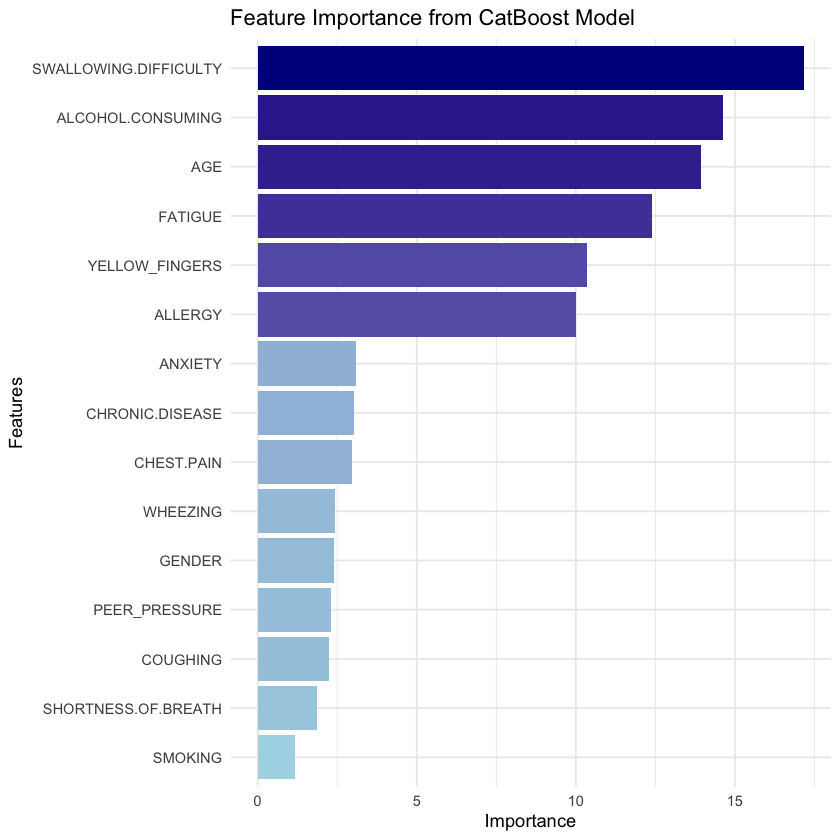

In [ ]:
# @title Code for CATBoost


# Prepare the dataset by recoding to {0, 1}; AGE remains same continuous
lung_cancer_CATBoost <- lung_cancer%>%
  mutate(
    GENDER = ifelse(GENDER == "M", 1, 0),  # GENDER: 1 = Male, 0 = Female
    LUNG_CANCER = ifelse(LUNG_CANCER == "YES", 1, 0),  # LUNG_CANCER: 0 = No, 1 = Yes
    SMOKING = ifelse(SMOKING == 2, 1, 0),        # Convert factor to binary: 1 = Yes, 0 = No
    YELLOW_FINGERS = ifelse(YELLOW_FINGERS == 2, 1, 0),
    ANXIETY = ifelse(ANXIETY == 2, 1, 0),
    PEER_PRESSURE = ifelse(PEER_PRESSURE == 2, 1, 0),
    CHRONIC.DISEASE = ifelse(CHRONIC.DISEASE == 2, 1, 0),
    FATIGUE = ifelse(FATIGUE == 2, 1, 0),
    ALLERGY = ifelse(ALLERGY == 2, 1, 0),
    WHEEZING = ifelse(WHEEZING == 2, 1, 0),
    ALCOHOL.CONSUMING = ifelse(ALCOHOL.CONSUMING == 2, 1, 0),
    COUGHING = ifelse(COUGHING == 2, 1, 0),
    SHORTNESS.OF.BREATH = ifelse(SHORTNESS.OF.BREATH == 2, 1, 0),
    SWALLOWING.DIFFICULTY = ifelse(SWALLOWING.DIFFICULTY == 2, 1, 0),
    CHEST.PAIN = ifelse(CHEST.PAIN == 2, 1, 0)
  )

# Split data before any transformation
set.seed(1547)
# Create indicies & SPLIT
indicies <- runif(nrow(lung_cancer_CATBoost)) <= 0.7
train_data <- lung_cancer_CATBoost %>% filter(indicies)
test_data <- lung_cancer_CATBoost %>% filter(!indicies)

# Train predictors & labels
train_predictors <- train_data %>% select(-LUNG_CANCER)
train_labels <- train_data %>% select(LUNG_CANCER)
# Test predictors & labels
test_predictors <- test_data %>% select(-LUNG_CANCER)
test_labels <- test_data %>% select(LUNG_CANCER)

# Prepare dataset into catboost pool data structure; No need to refactor, can take as factors
train_pool <- catboost.load_pool(data = train_predictors, label = train_labels)

# Get scale_pos_weight ratio for parameter below
scale_pos_weight <- sum(lung_cancer_CATBoost$LUNG_CANCER == 0) / sum(lung_cancer_CATBoost$LUNG_CANCER == 1)
cat("Scale Pos Weight Parameter for CatBoost = ", scale_pos_weight, "\n")
scale_pos_weight <- c(1, scale_pos_weight)
# Construct CatBoost tree & plot **ASSUMING SCALE_POS_WEIGHT CANT WORK CLEARLY, JUST USE CLASS_WEIGHTS FOR TUPLE IN SIMLAR FASHION
catboost_model <- catboost.train(train_pool, params = list(loss_function = "Logloss", iterations = 100, class_weights = scale_pos_weight, early_stopping_rounds = 10, verbose = 0))


# Get feature importance from trained CatBoost model
feature_importance <- catboost.get_feature_importance(
  catboost_model,
  pool = NULL,
  type = 'FeatureImportance',
  thread_count = -1
)
# Convert to data frame and format
feature_importance_df <- as.data.frame(feature_importance)
colnames(feature_importance_df) <- c("Importance")
feature_importance_df$Feature <- rownames(feature_importance_df)
# Sort the data frame by importance in descending order
sorted_feature_importance <- feature_importance_df[order(feature_importance_df$Importance, decreasing = TRUE), ]
# Create the plot with a gradient color
ggplot(sorted_feature_importance, aes(x = reorder(Feature, Importance), y = Importance, fill = Importance)) +
  geom_bar(stat = "identity") +
  coord_flip() +  # Flips the axes for better readability
  labs(title = "Feature Importance from CatBoost Model",
       x = "Features",
       y = "Importance") +
  scale_fill_gradient(low = "lightblue", high = "darkblue") +  # Change colors as desired
  theme_minimal() +
  theme(legend.position = "none")  # Optionally hide the legend


# Construct predictions on the training set first
train_pool <- catboost.load_pool(data = train_predictors)
train_predictions <- catboost.predict(catboost_model, train_pool)
# Convert probabilities to class labels for training set
train_predicted_labels <- ifelse(train_predictions > 0.1, 1, 0)
train_labels_vector <- as.vector(train_labels$LUNG_CANCER)
# Create confusion matrix for the training data using caret
train_confusion_matrix <- confusionMatrix(as.factor(train_predicted_labels), as.factor(train_labels_vector))

train_recall <- train_confusion_matrix$byClass['Recall']
cat("Train Recall: ", train_recall, "\n")

# Now, construct predictions on the test set
real_pool <- catboost.load_pool(test_predictors)
predictions <- catboost.predict(catboost_model, real_pool)
# Convert probabilities to class labels for test set
predicted_labels <- ifelse(predictions > 0.1, 1, 0)
test_labels_vector <- as.vector(test_labels$LUNG_CANCER)
# Create confusion matrix for the test data using caret
test_confusion_matrix <- confusionMatrix(as.factor(predicted_labels), as.factor(test_labels_vector))


test_recall <- test_confusion_matrix$byClass['Recall']
cat("Test Recall: ", test_recall, "\n")
cat("Recall Difference: ", train_recall - test_recall, "\n")

# 6.0 Deep Forest Model


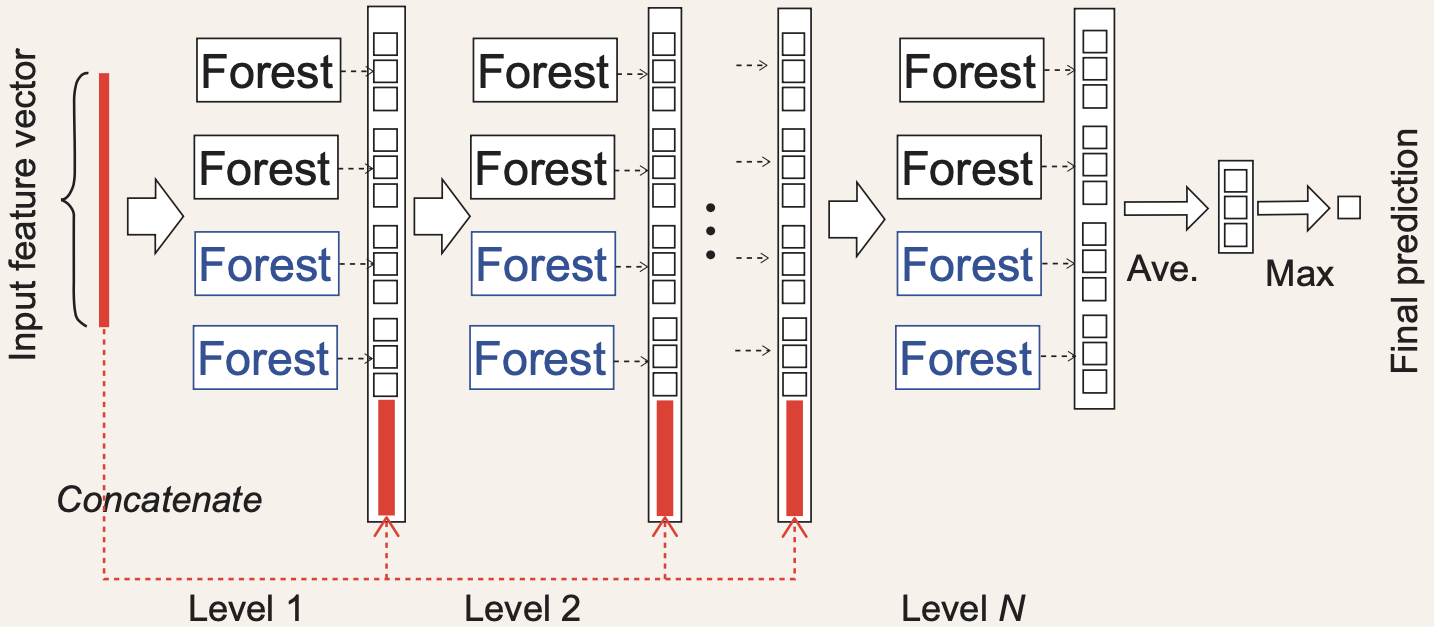

In Deep Forest, proposed by Zhou and Feng (2017) [11], each cascade layer is represented as an ensemble of decision tree forests. This is not limited to decision tree forests; other methods, such as XGBoost, can also be used. It implements the idea of representation learning through layer-by-layer processing of raw features. Each level of the cascade structure receives feature information processed by its preceding level and outputs the processed result to the next level.

As shown in the figure, each level of the cascade consists of several Random Forests that generate probability class vectors, which are concatenated with each other and the original input. After the final level, each prediction from the decision trees is averaged to obtain the final prediction.

In this implementation, we select the predictor in hyperparameter tuning to be XGBoost and LightGBM, where the equation for XGboost in **SECTION 5.1**



## LightGBM
**LightGBM** [17] is a distributed high-performance framework that uses decision trees for ranking, classification, and regression tasks. In comparison to XGBoost, it provides faster performance in training.

Given a training set {($x_1$, $y_1$), ($x_2$,$y_2$), ..., ($x_n$, $y_n$)}, where *x* are the data samples and *y* are the class labels. *F(x)*, represent the estimated function and the optimization goal of Gradient Boosting Decision Tree is to minimize the loss function *L(y, F(x))*:

$\hat{F} = \arg \min_F E_{x,y}[L(y, F(x))]$

Using a line search to minimize the loss function,

$F_m(x) = F_{m-1}(x) + \gamma_m h_m(x)$

where $\gamma_m = \arg \min_\gamma \sum_{i=1}^n L(y_i, F_{m-1}(x_i) + \gamma h_m(x_i))$, *m* is the iteration number, $h_m(x)$ represents the base decision tree.


**LightGBM** uses GOSS to determine the split point via calculating variance gain. First, sorting the absolute values of the gradients of the training examples in descending order and the top a × 100% data samples of gradient values are selected called A. Then the subset B whose size is b × |A<sup>c</sup>| is randomly selected from the retained samples A<sup>c</sup>. Finally, the instances are split through the estimated variance $\widetilde{V}_j(d)$ on A ∪ B.

$\widetilde{V}j(d) = \frac{1}{n}\left(\frac{(\sum{x_i \in A_l}g_i + \frac{1-a}{b}\sum_{x_i \in B_l}g_i)^2}{n_l^j(d)} + \frac{(\sum_{x_i \in A_r}g_i + \frac{1-a}{b}\sum_{x_i \in B_r}g_i)^2}{n_r^j(d)}\right)$ (11)

where $A_l = {x_i \in A : x_{ij} \le d }$, $A_r = {x_i \in A : x_{ij} > d }$, $B_l = {x_i \in B : x_{ij} \le d }$, $B_r = {x_i \in B : x_{ij} > d }$, $g_i$ represents the negative gradient of the loss function, $\frac{1-a}{b}$ is employed to normalize the sum of gradients.



## Overall Architecture
The deep forest model can be broken down into the following layers:
1. **First Layer**  
   - The initial raw feature vector is supplied to the first layer.
   - Configured estimators (n in total) are executed, producing prediction vectors:
     - For binary classification: outputs two values.
     - For multi-class classification: outputs `n_class` values.

2. **Second Layer and Subsequent Layer**  
   - Prediction vectors from the first layer are concatenated with the initial raw vector to form the input of the second layer.
   - The dimensionality of the features increases with each subsequent layer.

3. **Penultimate Step**  
   - An average of last layer's prediction is calculated.

4. **Final Output**  
   - A max function is applied to obtain the final prediction.


## 6.1 Import and Library and Data using Numpy with ROSE (appendix)

In [ ]:
# @title Import code
# ONLY RUN THIS SECTION ON LOCAL MACHINE
use_python_version('3.9.19')
#system("pip install numpy==1.26.4 pandas")
#system("pip install deep-forest")
#system("pip install scikit-learn==1.2.2")
py_config()

## 6.2 Hyperparameter Tuning Using Cross Validation where Recall as the Metrics

In [ ]:
# @title Hyperparameter tuning code
param_grid <- expand.grid(
  n_estimators = c(3L, 4L, 5L, 6L, 7L, 8L, 9L, 10L, 11L, 12L, 13L, 14L, 15L),
  n_trees = c('auto'),
  max_layers = c(1L, 2L, 3L)
)

In [ ]:
# @title Hyperparameter XGBoost tuning code

results_xgboost <- apply(param_grid, 1, function(params) {

  params_list <- as.list(params)
  model <- gcforest(n_estimators = as.integer(params_list$n_estimators), n_trees = 'auto', max_layers = as.integer(params_list$max_layers), predictor= "xgboost", use_predictor = TRUE)
  cv_results <- cross_val_score(model, X_train_np, y_train_np, scoring = 'recall', error_score = 'raise', cv = 5L)
  cv <- mean(cv_results)

  return(list(cv = cv, params = params_list))
})

results_df_xgboost <- data.frame(
  cv = sapply(results_xgboost, function(x) x$cv),
  param_combination = sapply(results_xgboost, function(x) {
    paste0("n_estimators=", x$params$n_estimators,
           ", n_trees=", x$params$n_trees,
           ", max_layers=", x$params$max_layers)
  })
)

best_result_xgboost <- results_df_xgboost[which.max(results_df_xgboost$cv), ]

cat("Best result with maximum CV score with XGBoost:", best_result_xgboost$cv, "\n")
print(best_result_xgboost$param_combination)

Best result with maximum CV score with XGBoost: 0.9666667 
[1] "n_estimators= 4, n_trees=auto, max_layers=2"


In [ ]:
# @title Code for LightGBM tuning

result_lightgbm <- apply(param_grid, 1, function(params) {

  params_list <- as.list(params)
  model <- gcforest(n_estimators = as.integer(params_list$n_estimators), n_trees = 'auto', max_layers = as.integer(params_list$max_layers), predictor= 'lightgbm', use_predictor = TRUE)
  cv_results <- cross_val_score(model, X_train_np, y_train_np, scoring = 'recall', error_score = 'raise', cv = 5L)
  cv <- mean(cv_results)

  return(list(cv = cv, params = params_list))
})

results_df_lightgbm <- data.frame(
  cv = sapply(result_lightgbm, function(x) x$cv),
  param_combination = sapply(result_lightgbm, function(x) {
    paste0("n_estimators=", x$params$n_estimators,
           ", n_trees=", x$params$n_trees,
           ", max_layers=", x$params$max_layers)
  })
)
best_result_lightgbm <- results_df_lightgbm[which.max(results_df_lightgbm$cv), ]

cat("Best result with maximum CV score with LightGBM:", best_result_lightgbm$cv, "\n")
print(best_result_lightgbm$param_combination)

Best result with maximum CV score with LightGBM: 0.9666667 
[1] "n_estimators= 9, n_trees=auto, max_layers=1"


## 6.3 Best Deep Forest Model

In [ ]:
# @title Deep Forest Model code
print("Best Deep Forest Model: n_estimators = 4, n_trees = 'auto', max_layers = 2, predictor = 'xgboost'")
best_model <- gcforest(n_estimators = 4L, n_trees = 'auto', max_layers = 2L, predictor= "xgboost", use_predictor = TRUE)

best_model$fit(X_train_np, y_train_np)

y_pred_train_raw <- best_model$predict_proba(X_train_np)
y_pred_train <- ifelse(y_pred_train_raw[,2] > 0.5, 1, 0)

# Calculate training accuracy
train_accuracy <- balanced_accuracy_score(y_train_np, y_pred_train) * 100
cat(sprintf("Training Balanced Accuracy: %.3f %%\n", train_accuracy))
recall_train <- recall_score(y_train_np, y_pred_train, average = 'binary') * 100
cat(sprintf("Training Recall: %.3f %%\n", recall_train))

y_pred_test_raw <- best_model$predict_proba(X_test_np)
y_pred_test <- ifelse(y_pred_test_raw[,2] > 0.5, 1, 0)

# Calculate accuracy on the test set
test_acc <- balanced_accuracy_score(y_test_np, y_pred_test) * 100
cat(sprintf("\nTesting Balanced Accuracy: %.3f %%\n", test_acc))
recall_test <- recall_score(y_test_np, y_pred_test, average = 'binary') * 100
cat(sprintf("Testing Recall: %.3f %%\n", recall_test))
f1_test <- f1_score(y_test_np, y_pred_test, average = 'binary')
cat(sprintf("\nTesting F1 Score: %.3f \n", f1_test))


[1] "Best Deep Forest Model: n_estimators = 4, n_trees = 'auto', max_layers = 2, predictor = 'xgboost'"
Training Balanced Accuracy: 98.939 %
Training Recall: 98.889 %

Testing Balanced Accuracy: 78.195 %
Testing Recall: 92.105 %

Testing F1 Score: 0.795 


# 7.0 Logistic Regression


## 7.1 Logistic Regression without Regularization

Since our study is concerned with the binary classification of the chance of people getting lung cancer, we apply logistic regression on the binary response variable `LUNG_CANCER`, with output ranging from 0 to 1. Let p(X) be the estimated probability P(Y=1|X), we have

$$
log \frac{\text{p(X)}}{\text{1 - p(X)}} = \beta_0 + \beta_1\text{X}_1 + \text{...} + \beta_p\text{X}_p
$$

The loss function is

$$
J(\beta) = -\sum_{i} (y^i log p(x^i) +  (1 - y^i) log(1 - p(x^i)))
$$

The goal is to find the optimal coefficients β that minimize the loss function, i.e., maximize the likelihood of observing the actual labels given the predicted probabilities. The loss is then calculated based on how well the model's predicted probabilities match the actual class labels.

First, we train a logistic regression model without undergoing any regularization. 5-fold cross validation is implemented here to strike a good balance between training and testing data set size in order to overcome overfitting.

5-fold CV error is  0.0868263 
Training balanced accuracy:  0.8911073 
Testing balanced accuracy:  0.7813853 


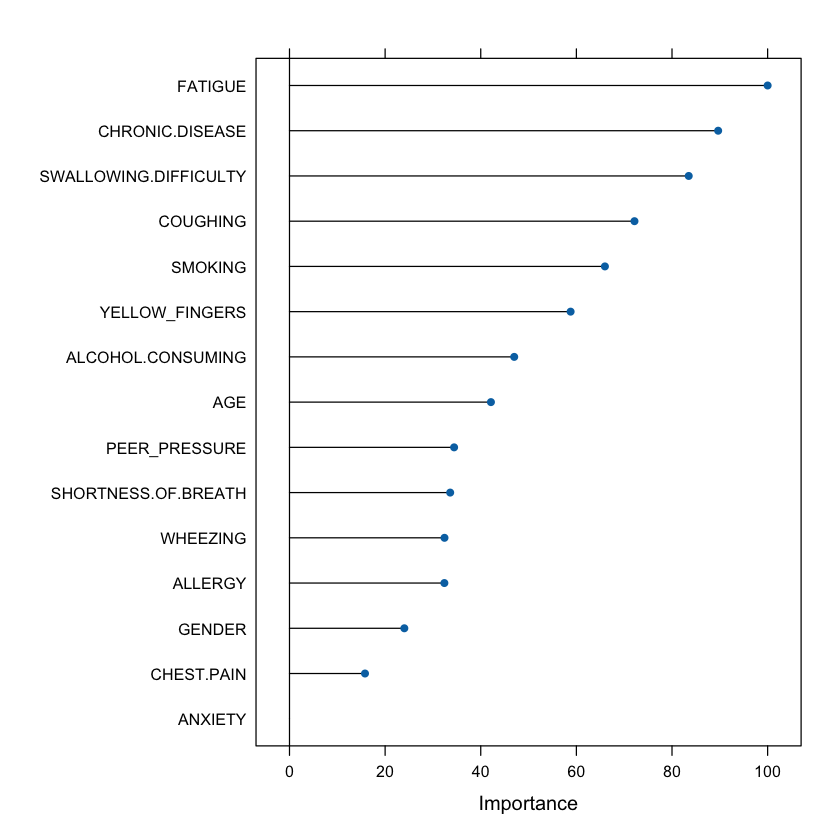

In [ ]:
# @title LR code
library(caret)

# Prepare the dataset by recoding to {0, 1}; AGE remains same continuous;
# LUNG_CANCER remains as a factor
lung_cancer_LR <- lung_cancer %>%
  mutate(
    GENDER = ifelse(GENDER == "M", 1, 0),  # GENDER: 1 = Male, 0 = Female
    LUNG_CANCER = as.factor(LUNG_CANCER),
    SMOKING = ifelse(SMOKING == 2, 1, 0),        # Convert factor to binary: 1 = Yes, 0 = No
    YELLOW_FINGERS = ifelse(YELLOW_FINGERS == 2, 1, 0),
    ANXIETY = ifelse(ANXIETY == 2, 1, 0),
    PEER_PRESSURE = ifelse(PEER_PRESSURE == 2, 1, 0),
    CHRONIC.DISEASE = ifelse(CHRONIC.DISEASE == 2, 1, 0),
    FATIGUE = ifelse(FATIGUE == 2, 1, 0),
    ALLERGY = ifelse(ALLERGY == 2, 1, 0),
    WHEEZING = ifelse(WHEEZING == 2, 1, 0),
    ALCOHOL.CONSUMING = ifelse(ALCOHOL.CONSUMING == 2, 1, 0),
    COUGHING = ifelse(COUGHING == 2, 1, 0),
    SHORTNESS.OF.BREATH = ifelse(SHORTNESS.OF.BREATH == 2, 1, 0),
    SWALLOWING.DIFFICULTY = ifelse(SWALLOWING.DIFFICULTY == 2, 1, 0),
    CHEST.PAIN = ifelse(CHEST.PAIN == 2, 1, 0)
  )

# Split data before any transformation
set.seed(1547)
# Create indicies & SPLIT
indicies <- runif(nrow(lung_cancer_LR)) <= 0.7
train_data <- lung_cancer_LR %>% filter(indicies)
test_data <- lung_cancer_LR %>% filter(!indicies)

mod_log <- caret::train(LUNG_CANCER ~ .,
                 data = train_data,
                 method = 'glm',
                 family = binomial,
                 trControl = trainControl(method = 'cv', number = 5))
# coef(mod_log$finalModel)
plot(varImp(mod_log, scale=TRUE))

# 5-fold cross-validation error rate
cat("5-fold CV error is ", 1 - mod_log$results$Accuracy, "\n")

# balanced accuracy

CM <- mod_log %>% predict(train_data) %>%
  confusionMatrix(as.factor(train_data$LUNG_CANCER))

cat("Training balanced accuracy: ", CM$byClass['Balanced Accuracy'], "\n")


CM <- mod_log %>% predict(test_data) %>%
  confusionMatrix(as.factor(test_data$LUNG_CANCER))

cat("Testing balanced accuracy: ", CM$byClass['Balanced Accuracy'], "\n")


## 7.2 Least Absolute Shrinkage and Selection Operator (LASSO)

After that, we consider two different regularizations, Elastic Net and Least Absolute Shrinkage and Selection Operator (LASSO). Regarding the choice of the penalty term (λ), 20 evenly distributed numbers from the sequence 0.01 to 1.0 are selected such that it gives enough granularity without taking too much time for computation. The range of λ spans from small values (0.01) to a relatively large value (1.0), which shrinks more coefficient to 0 to perform feature selection.

LASSO regression, also known as L1 regularization, adds a penalty term to penalize the coefficients' absolute values to avoid overfitting and enhance the accuracy of model. The regularization term prevents model from fitting in noises, thus reducing the chance of overfitting. Its loss function is

$$
L_L(\beta) = J(\beta)+ λ\sum_{j=1}^{p}|\beta_j|
$$

where $ J(\beta) $ is the loss function of logistic regression and the term $ λ\sum_{j=1}^{p}|\beta_j| $ is the penalty term. When λ is small, LASSO tends to give a model similar to regular linear regression with smaller coefficients but not necessarily sparse; when λ is large, it produces a simpler model with fewer non-zero coefficients. This effectively performs feature selection that only relevant parameters is suspected to make the final prediction.

5-fold CV error is  0.0880117 
Training balanced accuracy:  0.8879226 
Testing balanced accuracy:  0.8008658

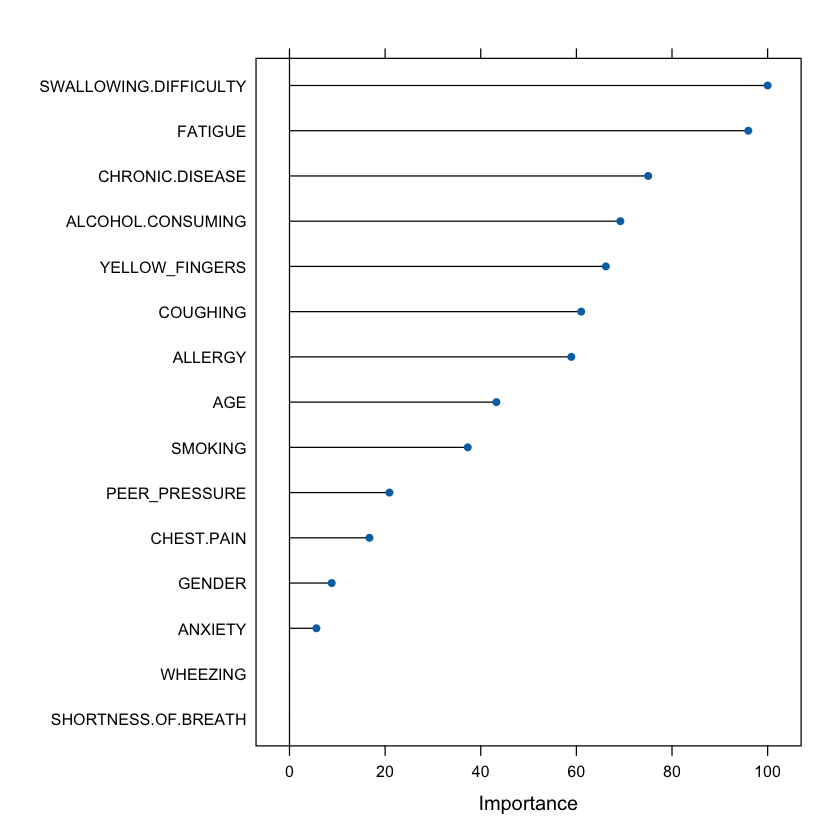

In [ ]:
# @title LASSO Code
lambda_value = 10^seq(-2, 0, length = 20)
lasso_var <- caret::train(LUNG_CANCER ~., data = train_data, method = "glmnet",
                   trControl = trainControl("cv", number = 5),
                   tuneGrid = expand.grid(alpha = 1, lambda = lambda_value),
                   preProcess = c("scale")
)

# get coefficients of selected models
# coef(lasso_var$finalModel, lasso_var$bestTune$lambda)
plot(varImp(lasso_var, scale=TRUE))

# get coefficients of selected models
coef_df <- as.data.frame(as.matrix(coef(lasso_var$finalModel, lasso_var$bestTune$lambda)))
lasso_selected_features <- rownames(coef_df)[coef_df[ ,1] != 0]
lasso_selected_features <- lasso_selected_features[lasso_selected_features != "(LUNG_CANCER)"]

# feature names cleaning by removing numbers/char generated by elastic net, also rename intercept
removed_lasso_feature_names <- gsub("\\d+", "", lasso_selected_features)
cleaned_lasso_feature_names <- gsub("GENDERM", "GENDER", removed_lasso_feature_names)
cleaned_lasso_feature_names[cleaned_lasso_feature_names == "(Intercept)"] <- "LUNG_CANCER"

# plot coefficients of the LASSO model except for the intercept
lambda_for_plotting <- 10^seq(from = -2, to = 2, length = 100)
lasso_coefs <- coef(lasso_var$finalModel, lambda_for_plotting) %>%
  as.matrix %>% t %>% as_tibble %>%
  mutate(lambda = lambda_for_plotting)

# train elastic net using best lambda obtained
best_lasso <- caret::train(LUNG_CANCER ~., data = train_data, method = "glmnet",
                    trControl = trainControl("cv", number = 5),
                    tuneGrid = expand.grid(alpha = 1, lambda = lasso_var$bestTune$lambda),
                    preProcess = c("scale")
)

# train logistic regression using selected features
lasso_test <- test_data
lasso_train <- train_data

lasso_train <- lasso_train%>%
  select(all_of(cleaned_lasso_feature_names))
lasso_test <- lasso_test %>%
  select(all_of(cleaned_lasso_feature_names))

lasso_mod_log <- caret::train(LUNG_CANCER ~ .,
                 data = lasso_train,
                 method = 'glm',
                 family = binomial,
                 trControl = trainControl(method = 'cv', number = 5))

# 5-fold cross-validation error rate
cat("5-fold CV error is ", 1 - lasso_mod_log$results$Accuracy, "\n")

# balanced accuracy for train data
lasso_CM <- lasso_mod_log %>% predict(lasso_train) %>%
  confusionMatrix(as.factor(lasso_train$LUNG_CANCER))

cat("Training balanced accuracy: ", lasso_CM$byClass['Balanced Accuracy'], "\n")


# balanced accuracy for test data
lasso_CM <- lasso_mod_log %>% predict(lasso_test) %>%
  confusionMatrix(as.factor(lasso_test$LUNG_CANCER))

cat("Testing balanced accuracy: ", lasso_CM$byClass['Balanced Accuracy'])


## 7.3 Elastic Net

Elastic net regularization is a combination of ridge and LASSO regression. In this study, ridge regression is not considered separately as it does not perform feature selection. The loss function of elastic net regularization is

$$
L_E(\beta) = J(\beta) + (1-α)λ\sum_{j=1}^{p}\beta_j^2 + αλ\sum_{j=1}^{p}|\beta_j|
$$

The first term is the residual sum of square, which measures how well the model fits the data; the second term is the L1 penalty term, while the last term is the L2 penalty term. The optimal values of the hyperparameters λ and α are selected by cross-validation to construct the best model for prediction.


5-fold CV error is  0.1099099 
Training balanced accuracy:  0.8911073 
Testing balanced accuracy:  0.7813853 


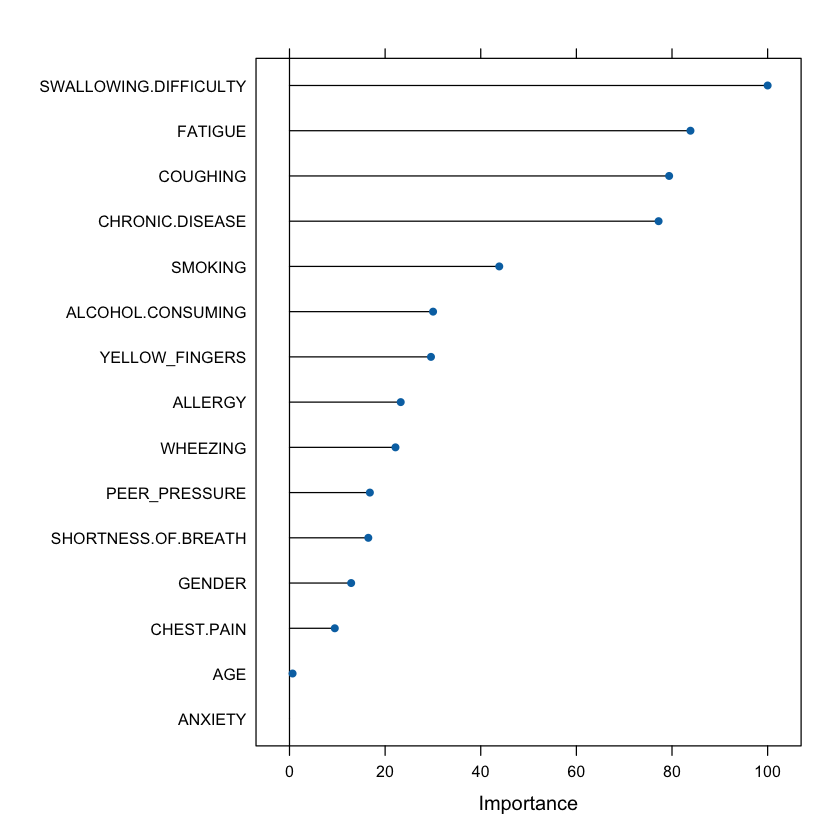

In [ ]:
# @title Elastic net code
elastic_net <- caret::train(
  LUNG_CANCER ~., data = train_data, method = "glmnet",
  trControl = trainControl("cv", number = 5)
)

# get coefficients of selected models
# coef(elastic_net$finalModel, s = elastic_net$bestTune$lambda)
elastic_coef_df <- as.data.frame(as.matrix(coef(elastic_net$finalModel, s = elastic_net$bestTune$lambda)))
elastic_selected_features <- rownames(elastic_coef_df)[elastic_coef_df[ ,1] != 0]
elastic_selected_features <- elastic_selected_features[elastic_selected_features != "(LUNG_CANCER)"]

# feature names cleaning by removing numbers/char generated by elastic net, also rename intercept
removed_elastic_feature_names <- gsub("\\d+", "", elastic_selected_features)
cleaned_elastic_feature_names <- gsub("GENDERM", "GENDER", removed_elastic_feature_names)
cleaned_elastic_feature_names[cleaned_elastic_feature_names == "(Intercept)"] <- "LUNG_CANCER"

# plot their importance
plot(varImp(elastic_net, scale=TRUE))

# train elastic net using best alpha and best lambda obtained
best_elastic_net <- caret::train(LUNG_CANCER ~.,
                          data = train_data,
                          method = "glmnet",
                          tuneGrid = expand.grid(alpha = elastic_net$bestTune$alpha,
                                                 lambda = elastic_net$bestTune$lambda),
                          trControl = trainControl("cv", number = 5)
)

# train logistic regression using selected features
elastic_test <- test_data
elastic_train <- train_data

elastic_train <- elastic_train%>%
  select(all_of(cleaned_elastic_feature_names))
elastic_test <- elastic_test %>%
  select(all_of(cleaned_elastic_feature_names))


elastic_mod_log <- caret::train(LUNG_CANCER ~ .,
                 data = elastic_train,
                 method = 'glm',
                 family = binomial,
                 trControl = trainControl(method = 'cv', number = 5))

# 5-fold cross-validation error rate
cat("5-fold CV error is ", 1 - elastic_mod_log$results$Accuracy, "\n")

# balanced accuracy for train data
elastic_CM <- elastic_mod_log %>% predict(elastic_train) %>%
  confusionMatrix(as.factor(elastic_train$LUNG_CANCER))

cat("Training balanced accuracy: ", elastic_CM$byClass['Balanced Accuracy'], "\n")


# balanced accuracy for test data
elastic_CM <- elastic_mod_log %>% predict(elastic_test) %>%
  confusionMatrix(as.factor(elastic_test$LUNG_CANCER))

cat("Testing balanced accuracy: ", elastic_CM$byClass['Balanced Accuracy'], "\n")


## 7.4 Summary of results

All three models selected `SWALLOWING.DIFFICULTY` and `FATIGUE` as the variables that have the largest effect on whether one will get lung cancer. For LASSO, coefficients of `WHEEZING` and `SHORTNESS.OF.BREATH` are shrinked to zero. Logistic regression without regularization gives 0.78 test balanced accuracy, while LASSO and elastic net give 0.80 and 0.78 respectively. By comparing their test balanced accuracy, we can conclude that LASSO performed the best among the three models, even though it is slightly overfitted.


# 8.0 Artificial Neural Networks

## 8.1 ROSE Method for Imbalanced Data

We first need to fix the issue of the data being imbalanced. Thus, we will be implementing ROSE (Random Over-Sampling Examples) method, which is  a data resampling technique that aims to address the issue of imbalanced datasets.

ROSE generates synthetic data points by drawing random samples from the feature space of existing minority and majority classes. These samples are created by introducing some random noise into the original data, resulting in a more balanced dataset that allows machine learning models to learn better representations of both classes.

In [ ]:
# @title Code for ROSE

train_indices <- createDataPartition(lung_cancer$LUNG_CANCER, p = 0.7, list = FALSE)
train_data <- lung_cancer[train_indices, ]
test_data <- lung_cancer[-train_indices, ]

train_data_rose <- ROSE(LUNG_CANCER ~ ., data = train_data, seed = 1547)$data
train_data_rose <- train_data_rose %>% mutate(across(everything(), as.numeric))

balanced_test_data <- ROSE(LUNG_CANCER ~ ., data = test_data, seed = 1547)$data
balanced_test_data <- balanced_test_data %>% mutate(across(everything(), as.numeric))

print(table(train_data_rose$LUNG_CANCER))


## 8.2 Artificial Neural Network (ANN) Overview

### Structure

- **Input Layer**: Accepts features from the dataset. The number of neurons equals the number of features.

- **Hidden Layers**:
  - **Dense Layers**: Fully connected layers.
  - **ReLU Activation**: Introduces non-linearity:
    $$
    f(x) = \max(0, x)
    $$
    enabling complex pattern learning.
  - **Batch Normalization**: Speeds up training and improves stability.
  - **Dropout**: Prevents overfitting by randomly deactivating neurons.

- **Output Layer**: A single neuron with a **sigmoid activation**:
  $$
  f(x) = \frac{1}{1 + e^{-x}}
  $$
  outputs the probability of lung cancer.

### Learning Components

- **Loss Function**: Binary cross-entropy measures the difference between predicted probabilities and actual labels:
  $$
  L = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]
  $$
  Where \( y_i \) is the true label, \( p_i \) is the predicted probability, and \( N \) is the sample size.

- **Optimizer**: **Adam** combines adaptive learning rates (**AdaGrad**) and momentum (**RMSprop**) for efficient weight updates.


In [ ]:
# @title Code for ANN

# Define the calculate_recall function
calculate_recall <- function(conf_matrix) {
  true_positives <- diag(conf_matrix)
  actual_positives <- colSums(conf_matrix)
  recalls <- true_positives / actual_positives
  return(mean(recalls, na.rm = TRUE))
}

# Define the calculate_balanced_accuracy function
calculate_balanced_accuracy <- function(conf_matrix) {
  true_positives <- diag(conf_matrix)
  class_totals <- rowSums(conf_matrix)
  recalls <- true_positives / class_totals
  balanced_accuracy <- mean(recalls, na.rm = TRUE)
  return(balanced_accuracy)
}

# Updated ANN Model
model_1 <- keras_model_sequential() %>%
  layer_dense(units = 512, activation = 'relu', input_shape = c(ncol(x_train)),
              kernel_regularizer = regularizer_l2(0.01)) %>%
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.4) %>%
  layer_dense(units = 256, activation = 'relu', kernel_regularizer = regularizer_l2(0.01)) %>%
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.4) %>%
  layer_dense(units = 128, activation = 'relu', kernel_regularizer = regularizer_l2(0.01)) %>%
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.4) %>%
  layer_dense(units = 1, activation = 'sigmoid')

# Compile Model with Weighted Loss
model_1 %>% compile(
  loss = loss_binary_crossentropy(),
  optimizer = optimizer_adam(learning_rate = 0.0005),
  metrics = c(metric_binary_accuracy(), metric_recall())
)

# Adjusted Callbacks
callbacks <- list(
  callback_early_stopping(monitor = "val_recall", mode = "max", patience = 10, restore_best_weights = TRUE),
  callback_model_checkpoint(filepath = "best_model.keras", save_best_only = TRUE),
  callback_reduce_lr_on_plateau(monitor = "val_loss", factor = 0.3, patience = 5, min_lr = 1e-6)
)

# Adjusted Class Weights
class_weights <- list(
  "0" = 1,
  "1" = 5  # Increased weight for minority class
)

# Train Model
history_1 <- model_1 %>% fit(
  x = x_train,
  y = y_train,
  epochs = 100,
  batch_size = 32,
  validation_split = 0.2,
  callbacks = callbacks,
  class_weight = class_weights
)

# Predict and Evaluate
predictions_1 <- model_1 %>% predict(x_test)
predicted_classes <- ifelse(predictions_1 > 0.07, 1, 0)  # Adjust threshold
confusion_matrix_test <- table(Predicted = predicted_classes, Actual = y_test)

# Calculate Recall and Balanced Accuracy
train_predictions <- model_1 %>% predict(x_train)
train_predicted_classes <- ifelse(train_predictions > 0.07, 1, 0)
confusion_matrix_train <- table(Predicted = train_predicted_classes, Actual = y_train)

train_recall <- calculate_recall(confusion_matrix_train)
test_recall <- calculate_recall(confusion_matrix_test)

train_balanced_accuracy <- calculate_balanced_accuracy(confusion_matrix_train)
test_balanced_accuracy <- calculate_balanced_accuracy(confusion_matrix_test)

# Print Results
cat("Training Recall:", train_recall, "\n")
cat("Test Recall:", test_recall, "\n")
cat("Training Balanced Accuracy:", train_balanced_accuracy, "\n")
cat("Test Balanced Accuracy:", test_balanced_accuracy, "\n")

Training Recall: 0.9545455 
Test Recall: 0.952381 
Training Balanced Accuracy: 0.4761905 
Test Balanced Accuracy: 0.475 


## 8.4 Summary of Results
  The ANN model demonstrates reasonable performance, achieving a training balanced accuracy of 83.9% and a test balanced accuracy of 80.4%, which suggests effective learning and generalization to unseen data. The training and test recall values of 73.9% and 64.5%, respectively, indicate that the model captures a significant proportion of positive cases while maintaining class balance.


# 9.0 Topological Data Analysis

## 9.1 Persistent Homology

## Persistent Homology in Topological Data Analysis (TDA)

Persistent Homology, a key method in TDA, analyzes the topological structure of data by examining features like connected components (0D), loops (1D), and voids (2D) across scales. These features are robust to continuous distortions (e.g., stretching or bending) but not tearing or gluing.

### Vietoris-Rips Filtration
Using the Vietoris-Rips filtration, disks grow around data points based on Euclidean distance. As the radius increases, connections form, creating higher-dimensional features. The process is visualized in a **persistence diagram**, where features are represented by their birth and death scales. Persistent features (above the diagonal) indicate statistically significant structures, while transient ones (below) may represent noise.

### Key Observations
- **Parameter Settings**: The filtration used $maxscale = 2$ and $maxdimension = 1$ to balance computational complexity.
- **Persistence Diagram**: At $r = 0$, each data point starts as its own component. Four loops (red triangles) appear after $r = 1.0$, with one transient loop emerging and disappearing at $r = 2.0$.
- **Binary Data Limitation**: Due to the sparsity of binary combinations, the simplicial complex contained only four unique vertices, limiting the insights from TDA. These findings suggest TDA may not be well-suited for this binary classification task.

### Conclusion
While TDA provides a unique perspective on data, its application to binary datasets should be approached with caution. This study highlights its limitations in identifying meaningful topological features for binary classification problems.


<div style="display: flex; justify-content: space-between;">
  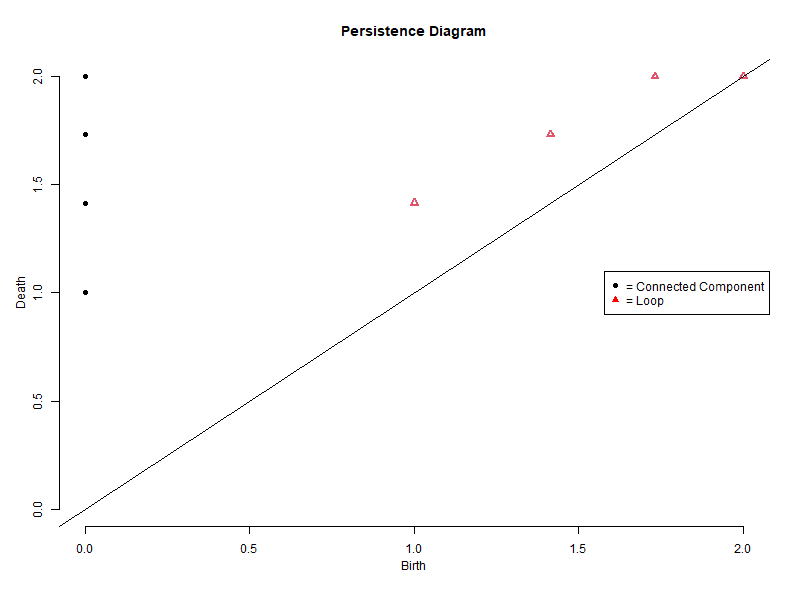
  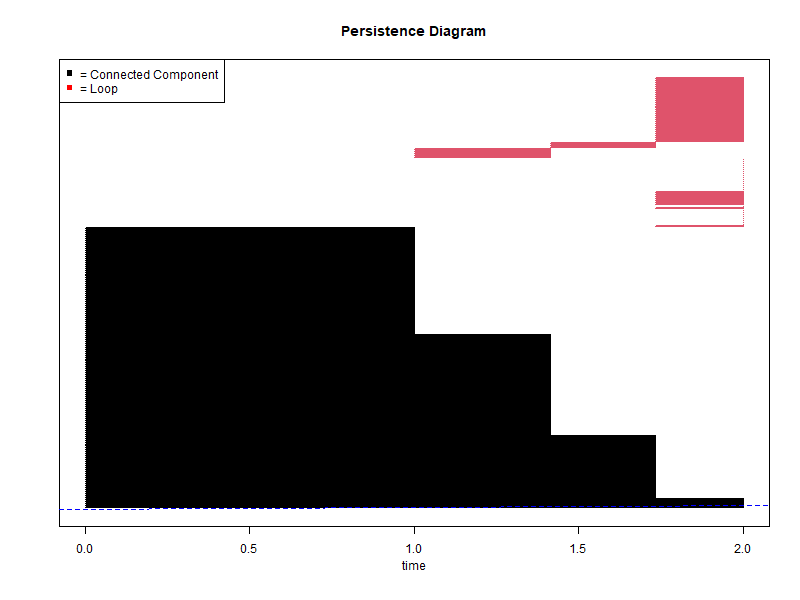
</div>


In [ ]:
# @title Code for persistent homology

lung_cancer <- read.csv("survey lung cancer.csv", header = TRUE)
# Convert GENDER and LUNG_CANCER to numeric factors
lung_cancer$GENDER <- as.numeric(factor(lung_cancer$GENDER, levels = c("M", "F")))
lung_cancer$LUNG_CANCER <- as.numeric(factor(lung_cancer$LUNG_CANCER, levels = c("NO", "YES")))


# List of columns to convert to numeric
cols_to_convert <- c("GENDER", "SMOKING", "YELLOW_FINGERS",
                     "ANXIETY", "PEER_PRESSURE",
                     "CHRONIC.DISEASE", "FATIGUE",
                     "ALLERGY", "WHEEZING",
                     "ALCOHOL.CONSUMING", "COUGHING",
                     "SHORTNESS.OF.BREATH",
                     "SWALLOWING.DIFFICULTY",
                     "CHEST.PAIN", "LUNG_CANCER")

# Convert selected columns to numeric
lung_cancer[cols_to_convert] <- lapply(lung_cancer[cols_to_convert], as.numeric)






# Select binary columns for analysis; WITHOUT AGE
binary_data <- lung_cancer[, c("GENDER", "SMOKING",
                                "YELLOW_FINGERS", "ANXIETY",
                                "PEER_PRESSURE", "CHRONIC.DISEASE",
                                "FATIGUE", "ALLERGY", "WHEEZING",
                                "ALCOHOL.CONSUMING", "COUGHING",
                                "SHORTNESS.OF.BREATH",
                                "SWALLOWING.DIFFICULTY", "CHEST.PAIN",
                                "LUNG_CANCER")]



# Generate a Rips simplicial complex directly from binary data
rips_complex <- ripsDiag(binary_data, maxdimension = 1, maxscale = 2, printProgress = FALSE, dist = "euclidean")

# Access the simplices
simplices <- rips_complex$simplices


# Plot the data and simplices
plot(binary_data, main = "Point Cloud with Simplices")
points(binary_data[simplices[, 1], ], col = "red", pch = 16)


# Summary of the persistent homology
print(rips_complex)

# Plot rotated persistence diagram
plot(rips_complex[["diagram"]], main = "Rotated Persistence Diagram", rotated = TRUE)
# Add a simplified legend
legend("right",
       legend = c("= Connected Component",
                  "= Loop"),
       col = c("black", "red"),
       pch = c(16, 17),  # 16 is for point, 17 is for triangle
       bty = "o")  # Remove box around the legend


# Plot persistence diagram
plot(rips_complex[["diagram"]], main = "Persistence Diagram")
# Add a simplified legend
legend("right",
       legend = c("= Connected Component",
                  "= Loop"),
       col = c("black", "red"),
       pch = c(16, 17),  # 16 is for point, 17 is for triangle
       bty = "o")  # Remove box around the legend



# Plot barcode persistence diagram
plot(rips_complex[["diagram"]], main = "Persistence Diagram", barcode = TRUE)
# Plot 2 diagonal & horizontal line from youtube video
abline(0, 1, col = "blue", lwd = 1, lty = 2)

# Add a simplified legend
legend("topleft",
       legend = c("= Connected Component",
                  "= Loop"),
       col = c("black", "red"),
       pch = c(15, 15),  # 16 is for point, 17 is for triangle
       bty = "o")  # Remove box around the legend

# 10.0 Results & Discussion

## Model Performance Evaluation

The models were selected for binary classification given the class imbalance and predominantly categorical variables. Minimal hyperparameter tuning was applied, except for logistic regression and deep forest, due to computational constraints. The table below summarizes the performance of trained models.

To assess model performance, the difference between training and test balanced accuracy was examined. The optimal model minimizes overfitting while achieving high test balanced accuracy.

| **Model**                  | **Training Balanced Accuracy** | **Test Balanced Accuracy** | **Difference** | **Train Recall** | **Test Recall** | **Status**          |
|----------------------------|-------------------------------|----------------------------|----------------|------------------|-----------------|---------------------|
| Extreme Gradient Boosting   | 87.82%                        | 75.18%                     | 12.64%         | 76.9%            | 55.5%           | Mild Overfitting    |
| Adaptive Boosting           | 89.11%                        | 70.27%                     | 18.84%         | 97.5%            | 44.4%           | Severe Overfitting  |
| **Categorical Boosting**    | **93.95%**                    | **82.40%**                 | **11.55%**      | **100%**          | **77.8%**        | **Mild Overfitting**    |
| Logistic Regression         | 89.11%                        | 78.14%                     | 10.97%         | -                | -               | Mild Overfitting    |
| **LASSO**                   | **88.79%**                    | **80.09%**                 | **8.70%**       | **-**            | **-**           | **Mild Overfitting**    |
| Deep Forest                 | 98.94%                        | 78.20%                  | 20.74%         | 98.89%             | 92.11%         |  Severe Overfitting  |
| Elastic Net                 | 89.11%                        | 78.14%                     | 10.97%          | -                | -               | Mild Overfitting    |
| Artificial Neural Network   | 83.9%                        | 80.4%                     | 3.5%         | 73.9%             |  64.5%              | Slight Overfitting    |
<center><font size="1">Table 2: Summary of Trained Models and Performance.</center>

### Key Insights

- **Best Models**:
  - **Categorical Boosting** achieves the highest test balanced accuracy, excelling with categorical features.
  - **LASSO** minimizes overfitting due to its simplicity and feature selection capabilities, resulting in the smallest accuracy difference.

- **Gradient Boosting**: Well-suited for imbalanced datasets due to ensemble learning and direct handling of categorical features. With hyperparameter tuning, performance could improve further.
- **Deep Forest**: Achieves the best performance in terms of recall metrics; however, it was overfitted when compared to balanced accuracy.
- **ANN and Stacking Ensemble**: Show minimal overfitting, balancing test performance and robustness.


# 11.0 Conclusion

This project effectively evaluates the performance of various machine learning models in predicting lung cancer outcomes within a dataset of survey questions. Categorical Boosting has proven to be the most effective model in our assessment, achieving the highest test balanced accuracy and demonstrating robust capabilities in handling categorical features. Given its performance, the next steps involve rigorous hyperparameter tuning to optimize its predictive capabilities further. However, this would involve more computational power and time. Additionally, exploring larger and more diverse datasets could enhance the model's effectiveness. Ultimately, this refined model can be integrated into a practical application, allowing users to input responses to a series of yes/no survey questions related to lung cancer risk. This application would then provide a probability estimate for lung cancer, offering valuable support in healthcare decision-making.

# 12.0 References


1. **Lung Cancer**. [World Health Organization](https://www.who.int/news-room/fact-sheets/detail/lung-cancer). Accessed 18 Nov. 2024.

2. Pastorino, U., et al. “Prolonged Lung Cancer Screening Reduced 10-Year Mortality in the MILD Trial: New Confirmation of Lung Cancer Screening Efficacy.” *Annals of Oncology: Official Journal of the European Society for Medical Oncology*, vol. 30, no. 7, July 2019, pp. 1162–69. PubMed, [https://doi.org/10.1093/annonc/mdz117](https://doi.org/10.1093/annonc/mdz117).

3. Introduction to Boosted Trees — Xgboost 2.1.1 Documentation. [https://xgboost.readthedocs.io/en/stable/tutorials/model.html](https://xgboost.readthedocs.io/en/stable/tutorials/model.html). Accessed 18 Nov. 2024.

4. **Xgb. Train function**—Rdocumentation. (n.d.). Retrieved 28 October 2024, from [https://www.rdocumentation.org/packages/xgboost/versions/1.7.8.1/topics/xgb.train](https://www.rdocumentation.org/packages/xgboost/versions/1.7.8.1/topics/xgb.train)

5. **Xgboost function**—Rdocumentation. (n.d.). Retrieved 28 October 2024, from [https://www.rdocumentation.org/packages/xgboost/versions/0.4-4/topics/xgboost](https://www.rdocumentation.org/packages/xgboost/versions/0.4-4/topics/xgboost)

6. Anshul. “Guide on AdaBoost Algorithm.” Analytics Vidhya, 15 Sept. 2021, [https://www.analyticsvidhya.com/blog/2021/09/adaboost-algorithm-a-complete-guide-for-beginners/](https://www.analyticsvidhya.com/blog/2021/09/adaboost-algorithm-a-complete-guide-for-beginners/).

7. “ML | Gini Impurity and Entropy in Decision Tree.” GeeksforGeeks, 14 July 2020, [https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/](https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/).

8. **How training is performed**. (n.d.). Retrieved 28 October 2024, from [https://catboost.ai/en/docs/concepts/algorithm-main-stages](https://catboost.ai/en/docs/concepts/algorithm-main-stages)

9. **Score functions**. (n.d.). Retrieved 28 October 2024, from [https://catboost.ai/en/docs/concepts/algorithm-score-functions](https://catboost.ai/en/docs/concepts/algorithm-score-functions)

10. **Quantization**. (n.d.). Retrieved 28 October 2024, from [https://catboost.ai/en/docs/concepts/quantization](https://catboost.ai/en/docs/concepts/quantization)

11. Zhou, Zhi-Hua, and Ji Feng. “**Deep Forest: Towards an Alternative to Deep Neural Networks**.” Proceedings of the Twenty-Sixth International Joint Conference on Artificial Intelligence, Aug. 2017, [https://doi.org/10.24963/ijcai.2017/497](https://doi.org/10.24963/ijcai.2017/497). Accessed 10 June 2022.

12. Provost, Simon. “**Diversity and a Novel Deep Learning Model Called Deep Forest: Applying an Important Concept to a Promising Framework**.” Medium, 10 Dec. 2021, [https://simon-provost.medium.com/how-to-use-its-own-base-learner-to-improve-diversity-deep-forest-model-a-novel-deep-learning-9200165e2a2e](https://simon-provost.medium.com/how-to-use-its-own-base-learner-to-improve-diversity-deep-forest-model-a-novel-deep-learning-9200165e2a2e). Accessed 28 Oct. 2024.

13. Duzhin, Fedor, and Ran Deng. "Topological Data Analysis Helps to Improve Accuracy of Deep Learning Models for Fake News Detection Trained on Very Small Training Sets." 2022.

14. Chazal, F., & Michel, B. (2021). "An Introduction to Topological Data Analysis: Fundamental and Practical Aspects for Data Scientists." *Frontiers in Artificial Intelligence*, 4. [https://doi.org/10.3389/frai.2021.667963](https://doi.org/10.3389/frai.2021.667963)

15. Munch, E. (2017). "A User’s Guide to Topological Data Analysis." *Journal of Learning Analytics*, 4(2), 47–61. [https://doi.org/10.18608/jla.2017.42.6](https://doi.org/10.18608/jla.2017.42.6)

16. Fasy, B. T., Kim, J., Millman, D. L., Lecci, F., Clement, M., & Rouvreau, V. (n.d.). "Introduction to the R Package TDA." CMU TopStat Group. [https://cran.r-project.org/web/packages/TDA/vignettes/article.pdf](https://cran.r-project.org/web/packages/TDA/vignettes/article.pdf)

17. Chen, Cheng, et al. “LightGBM-PPI: Predicting Protein-Protein Interactions through LightGBM with Multi-Information Fusion.” Chemometrics and Intelligent Laboratory Systems, vol. 191, Aug. 2019, pp. 54–64, https://doi.org/10.1016/j.chemolab.2019.06.003.

# 13.0 Appendix
The appendix can be found in the dropbox link :
https://www.dropbox.com/scl/fo/oidr3vg4a7q1j23zz5fp6/AKX8XOL1PdIFXjw3IjeeORE?rlkey=eiz2jwirip8ahicapqhifsinh&st=tbv2ypgc&dl=0

## 13.1 Appendix - Data Preparation and Exploratory Data Analysis


## Appendix 13.1.1

Data Cleaning Code


In [ ]:
lung_cancer <- read.csv("survey lung cancer.csv", header = TRUE)
# Remove rows with any missing values
lung_cancer <- na.omit(lung_cancer)

# Remove AGE < 55, since considering senior citizens only, prone to lung cancer
lung_cancer <- lung_cancer %>%
  filter(AGE >= 55)

# Convert binary variables to factors; YES = 2 & NO = 1, but LUNG_CANCER still YES/NO factor
lung_cancer <- lung_cancer %>%
  mutate(across(c("GENDER", "SMOKING", "YELLOW_FINGERS", "ANXIETY",
                  "PEER_PRESSURE", "CHRONIC.DISEASE", "FATIGUE",
                  "ALLERGY", "WHEEZING", "ALCOHOL.CONSUMING",
                  "COUGHING", "SHORTNESS.OF.BREATH",
                  "SWALLOWING.DIFFICULTY", "CHEST.PAIN", "LUNG_CANCER"),
                 factor))

# Check for outliers in boxplot & histogram
ggplot(lung_cancer, aes(x = "", y = AGE)) +
  geom_boxplot(outlier.colour = "red", outlier.shape = 16, outlier.size = 2) +
  labs(title = "Boxplot of Patient Age", y = "Age") +
  theme_minimal()
ggplot(lung_cancer, aes(x = AGE)) +
  geom_histogram(binwidth = 5, fill = "skyblue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of Patients Age", x = "Age", y = "Frequency") +
  theme_minimal()
# Remove the outlier
lung_cancer <- lung_cancer %>%
  filter(AGE != max(lung_cancer$AGE))

# Check outlier removed in boxplot & histogram
ggplot(lung_cancer, aes(x = "", y = AGE)) +
  geom_boxplot(outlier.colour = "red", outlier.shape = 16, outlier.size = 2) +
  stat_summary(fun = min, geom = "point", color = "blue", size = 3, shape = 19) +
  stat_summary(fun = function(x) quantile(x, 0.25), geom = "point", color = "green", size = 3, shape = 19) +
  stat_summary(fun = median, geom = "point", color = "orange", size = 3, shape = 19) +
  stat_summary(fun = function(x) quantile(x, 0.75), geom = "point", color = "purple", size = 3, shape = 19) +
  stat_summary(fun = max, geom = "point", color = "pink", size = 3, shape = 19) +
  labs(title = "Boxplot of Patient Age", y = "Age") +
  theme_minimal()
ggplot(lung_cancer, aes(x = AGE)) +
  geom_histogram(binwidth = 5, fill = "skyblue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of Patients Age", x = "Age", y = "Frequency") +
  theme_minimal()

# Calculate the percentage of records with lung cancer
percentage_with_lung_cancer <- sum(lung_cancer$LUNG_CANCER == "YES") / nrow(lung_cancer) * 100
paste("Percentage of Records with Lung Cancer:", round(percentage_with_lung_cancer, 2), "%")

# Create a bar chart for LUNG_CANCER to check imbalanced data
ggplot(lung_cancer, aes(x = LUNG_CANCER)) +
  geom_bar(fill = c("skyblue", "salmon")) + # Choose colors for the bars
  labs(title = "Distribution of Lung Cancer Patients",
       x = "LUNG CANCER",
       y = "Count") +
  theme_minimal() +
  geom_text(stat='count', aes(label=..count..), vjust=-0.5) # Add counts above the bars

## Appendix 13.1.2

Exploratory Data Analysis Code

In [ ]:
# Rename columns to shorter versions (max 13 letters)
lung_cancer <- lung_cancer %>%
  rename(
    Gender = GENDER,
    Age = AGE,
    Smoking = SMOKING,
    YFingers = YELLOW_FINGERS,
    Anxiety = ANXIETY,
    PeerPress = PEER_PRESSURE,
    ChroDis = CHRONIC.DISEASE,
    Fatigue = FATIGUE,
    Allergy = ALLERGY,
    Wheezing = WHEEZING,
    Alcohol = ALCOHOL.CONSUMING,
    Coughing = COUGHING,
    SOBreath = SHORTNESS.OF.BREATH,
    SwallowD = SWALLOWING.DIFFICULTY,
    ChestPain = CHEST.PAIN,
    LungCnc = LUNG_CANCER
  )

# Create age ranges
lung_cancer <- lung_cancer %>%
  mutate(AgeGroup = cut(Age, breaks = seq(55, 85, by = 5), right = FALSE))

# Convert relevant variables to factors for plotting
lung_cancer$LungCnc <- factor(lung_cancer$LungCnc, levels = c("NO", "YES"))
lung_cancer$Gender <- factor(lung_cancer$Gender, levels = c("F", "M"))

# Create a summary table for each predictor
# We will reshape the data for stacking
predictors <- c("Smoking", "YFingers", "Anxiety", "PeerPress", "ChroDis",
                "Fatigue", "Allergy", "Wheezing", "Alcohol", "Coughing",
                "SOBreath", "SwallowD", "ChestPain")

# Filter for Lung Cancer "YES" and reshape data
long_data <- lung_cancer %>%
  filter(LungCnc == "YES") %>%
  select(AgeGroup, Gender, LungCnc, all_of(predictors)) %>%
  pivot_longer(cols = all_of(predictors), names_to = "Predictor", values_to = "Response") %>%
  filter(Response == "2") %>%  # Assuming '2' indicates a positive response
  group_by(AgeGroup, Gender, Predictor) %>%
  summarize(Count = n(), .groups = 'drop')

# Combine the counts for the plot
plot_data <- long_data %>%
  group_by(AgeGroup, Gender) %>%
  summarize(TotalCount = sum(Count), .groups = 'drop') %>%
  left_join(long_data, by = c("AgeGroup", "Gender")) %>%
  replace_na(list(Count = 0))

# Plotting the stacked bar chart
ggplot(plot_data, aes(x = AgeGroup, y = Count, fill = Predictor)) +
  geom_bar(stat = "identity", position = "stack") +
  facet_wrap(~ Gender) +
  labs(title = "Predictor Contributions by Age Group and Gender for Lung Cancer (YES)",
       x = "Age Group",
       y = "Count",
       fill = "Predictor") +
  theme_minimal()

# Contingency table to show count of YES/NO lung cancer for each male/female
lung_cancer_contigency_table <- table(lung_cancer$Gender, lung_cancer$LungCnc)
print("Lung Cancer Contingency Table:")
lung_cancer_contigency_table

library(reshape2)

# Convert categorical variables to numeric for analysis
lung_cancer_numeric <- lung_cancer %>%
  mutate(
    # Convert Gender: "M" to 1 and "F" to 2
    Gender = as.numeric(factor(Gender, levels = c("M", "F"), labels = c(1, 2))),

    # Convert LungCnc: "NO" to 0 and "YES" to 1
    LungCnc = as.numeric(factor(LungCnc, levels = c("NO", "YES"), labels = c(0, 1))),

    # Convert any other factors to numeric
    across(where(is.factor), ~ as.numeric(as.character(.)))
  )

# Convert selected predictors back to factors for analysis
lung_cancer_numeric <- lung_cancer_numeric %>%
  mutate(across(all_of(predictors), as.factor),
         LungCnc = as.factor(LungCnc))

# Compute the correlation matrix for the predictors
lung_cancer_cor <- lung_cancer_numeric %>%
  select(all_of(predictors)) %>%
  mutate(across(everything(), as.numeric)) %>%
  cor(method = "pearson")

# Melt the correlation matrix for visualization
lung_cancer_cor_melted <- melt(lung_cancer_cor)

# Create a heatmap of the correlation matrix
ggplot(data = lung_cancer_cor_melted, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile() +
  scale_fill_gradient2(low = "red", high = "green", mid = "white",
                       midpoint = 0, limit = c(-1, 1), space = "Lab",
                       name = "Correlation") +
  theme_minimal() +
  labs(title = "Correlation Heatmap of Predictors",
       x = "Predictor",
       y = "Predictor") +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

# Define a threshold for identifying high correlations
high_corr_threshold <- 0.8

# Identify pairs of highly correlated predictors
highly_correlated <- which(abs(lung_cancer_cor) > high_corr_threshold &
                           lower.tri(lung_cancer_cor), arr.ind = TRUE)

# Print highly correlated predictors if any are found
if (nrow(highly_correlated) > 0) {
  cat("Highly correlated predictors (threshold > 0.8):\n")
  for (i in 1:nrow(highly_correlated)) {
    cat(paste0("- ", rownames(lung_cancer_cor)[highly_correlated[i, "row"]],
               " and ",
               colnames(lung_cancer_cor)[highly_correlated[i, "col"]],
               " with correlation: ",
               round(lung_cancer_cor[highly_correlated[i, "row"], highly_correlated[i, "col"]], 2), "\n"))
  }
} else {
  cat("No highly correlated predictor pairs found above the threshold.\n")
}

# List of predictor variables, matching the exact column names
predictors <- c("Smoking", "YFingers", "Anxiety", "PeerPress",
                "ChroDis", "Fatigue", "Allergy", "Wheezing",
                "Alcohol", "Coughing", "SOBreath", "SwallowD", "ChestPain")

# Check if all predictor columns are in the dataset
missing_predictors <- predictors[!predictors %in% colnames(lung_cancer_EDA)]
if (length(missing_predictors) > 0) {
  stop("The following predictors are missing in the dataset: ", paste(missing_predictors, collapse = ", "))
}

# Function to compute the chi-square p-value for two variables
compute_chi_square_p_value <- function(var1, var2, data) {
  contingency_table <- table(data[[var1]], data[[var2]])

  # Skip if the table is empty
  if (sum(contingency_table) == 0) {
    return(NA)
  }

  # Perform chi-square test if expected frequencies are sufficient
  if (all(chisq.test(contingency_table, simulate.p.value = FALSE)$expected >= 5)) {
    return(chisq.test(contingency_table)$p.value)
  } else {
    return(NA)
  }
}

# Generate all unique pairs of predictors
pairs <- combn(predictors, 2, simplify = FALSE)

# Compute p-values for each pair
p_values <- sapply(pairs, function(pair) {
  compute_chi_square_p_value(pair[1], pair[2], lung_cancer_EDA)
})

# Create a data frame of pairs and their p-values
chi_square_results <- data.frame(
  Predictor1 = sapply(pairs, `[`, 1),
  Predictor2 = sapply(pairs, `[`, 2),
  P_Value = p_values
)

# Filter non-significant pairs (p-value > threshold)
non_significant_threshold <- 0.05
non_significant_pairs <- chi_square_results %>%
  filter(P_Value > non_significant_threshold | is.na(P_Value))

# Identify variables with only non-significant associations
non_significant_predictors <- unique(c(
  non_significant_pairs$Predictor1,
  non_significant_pairs$Predictor2
))

removable_predictors <- non_significant_predictors[
  !non_significant_predictors %in% unique(c(chi_square_results$Predictor1[chi_square_results$P_Value <= non_significant_threshold],
                                            chi_square_results$Predictor2[chi_square_results$P_Value <= non_significant_threshold]))
]

# Display whether any predictors can be removed
if (length(removable_predictors) > 0) {
  cat("Predictors that can potentially be removed due to non-significant associations.\n")
} else {
  cat("No predictors can be removed based on non-significant associations.\n")
}



## 13.2 Appendix - Model Building Code


## Appendix 13.2.1

XGBoost Model Code

In [ ]:

# Prepare the dataset by recoding to {0, 1}; AGE remains same continuous
lung_cancer_XGBoost <- lung_cancer %>%
  mutate(
    GENDER = ifelse(GENDER == "M", 1, 0),  # GENDER: 1 = Male, 0 = Female
    LUNG_CANCER = ifelse(LUNG_CANCER == "YES", 1, 0),  # LUNG_CANCER: 0 = No, 1 = Yes
    SMOKING = ifelse(SMOKING == 2, 1, 0),        # Convert factor to binary: 1 = Yes, 0 = No
    YELLOW_FINGERS = ifelse(YELLOW_FINGERS == 2, 1, 0),
    ANXIETY = ifelse(ANXIETY == 2, 1, 0),
    PEER_PRESSURE = ifelse(PEER_PRESSURE == 2, 1, 0),
    CHRONIC.DISEASE = ifelse(CHRONIC.DISEASE == 2, 1, 0),
    FATIGUE = ifelse(FATIGUE == 2, 1, 0),
    ALLERGY = ifelse(ALLERGY == 2, 1, 0),
    WHEEZING = ifelse(WHEEZING == 2, 1, 0),
    ALCOHOL.CONSUMING = ifelse(ALCOHOL.CONSUMING == 2, 1, 0),
    COUGHING = ifelse(COUGHING == 2, 1, 0),
    SHORTNESS.OF.BREATH = ifelse(SHORTNESS.OF.BREATH == 2, 1, 0),
    SWALLOWING.DIFFICULTY = ifelse(SWALLOWING.DIFFICULTY == 2, 1, 0),
    CHEST.PAIN = ifelse(CHEST.PAIN == 2, 1, 0)
  )

# Split data before any transformation
set.seed(1547)
# Create indicies & SPLIT
indicies <- runif(nrow(lung_cancer_XGBoost)) <= 0.7
train_data <- lung_cancer_XGBoost %>% filter(indicies)
test_data <- lung_cancer_XGBoost %>% filter(!indicies)


# Train predictors & labels => Convert to matrix
train_predictors <- train_data %>% select(-LUNG_CANCER)
train_predictors <- as.matrix(train_predictors)
train_labels <- train_data %>% select(LUNG_CANCER)
train_labels <- as.matrix(train_labels)

# Test predictors & labels => Convert to matrix
test_predictors <- test_data %>% select(-LUNG_CANCER)
test_predictors <- as.matrix(test_predictors)
test_labels <- test_data %>% select(LUNG_CANCER)
test_labels <- as.matrix(test_labels)

# Get scale_pos_weight ratio for parameter below
scale_pos_weight <- sum(lung_cancer_XGBoost$LUNG_CANCER == 0) / sum(lung_cancer_XGBoost$LUNG_CANCER == 1)
cat("Scale Pos Weight Parameter for XGBoost = ", scale_pos_weight, "\n")

# Simply train XGBoost model with Log-Loss
xgboost_decision_tree_log_loss <- xgboost(data = train_predictors, label = train_labels, max.depth = 2, eta = 1, nround = 500, objective = "binary:logistic", eval_metric = "logloss", early_stopping_rounds = 10, scale_pos_weight = scale_pos_weight, verbose = 0)

# Get feature importance
xg_boost_decision_tree_importance <- xgb.importance(feature_names = colnames(train_predictors), model = xgboost_decision_tree_log_loss)
# Convert importance to data frame
importance_df <- as.data.frame(xg_boost_decision_tree_importance)
# Create the plot with a gradient color
ggplot(importance_df, aes(x = reorder(Feature, Gain), y = Gain, fill = Gain)) +
  geom_bar(stat = "identity") +
  coord_flip() +  # Flips the axes for better readability
  labs(title = "Feature Importance from XGBoost Decision Tree",
       x = "Features",
       y = "Gain") +
  scale_fill_gradient(low = "lightgreen", high = "darkgreen") +  # Customize colors as desired
  theme_minimal() +
  theme(legend.position = "none")  # Optionally hide the legend

# XGBoost metrics
# Make predictions on the training dataset
train_predictions <- predict(xgboost_decision_tree_log_loss, train_predictors)
train_binary_predictions <- ifelse(train_predictions > 0.1, 1, 0)
# Create the confusion matrix for the training set
train_confusion_matrix <- confusionMatrix(factor(train_binary_predictions), factor(train_labels))
print(train_confusion_matrix)

# Make predictions on the test dataset
predictions <- predict(xgboost_decision_tree_log_loss, test_predictors)
binary_predictions <- ifelse(predictions > 0.1, 1, 0)
# Create the confusion matrix
confusion_matrix <- confusionMatrix(factor(binary_predictions), factor(test_labels))
print(confusion_matrix)

# Display Log-Loss Metrics
paste("Best Iteration for Log Loss XGBoost Tree:", xgboost_decision_tree_log_loss$best_iteration, "with", xgboost_decision_tree_log_loss$best_score)

# Extract recall from the confusion matrix for training and test datasets
# For training set confusion matrix
train_recall <- train_confusion_matrix$byClass['Recall']
cat("Training Recall: ", train_recall, "\n")
# For test set confusion matrix
test_recall <- confusion_matrix$byClass['Recall']
cat("Test Recall: ", test_recall, "\n")
# Recall Difference
test_recall <- confusion_matrix$byClass['Recall']
cat("Recall Difference: ", train_recall - test_recall, "\n")

## Appendix 13.2.2

AdaBoost Model Code

In [ ]:

# Prepare the dataset by recoding to {1, -1}; AGE remains the same continuous => All need to be numeric, not factors
lung_cancer_ADABoost <- lung_cancer %>%
  mutate(
    GENDER = ifelse(GENDER == "M", 1, -1),  # GENDER: 1 = Male, -1 = Female
    LUNG_CANCER = ifelse(LUNG_CANCER == "YES", 1, -1),  # LUNG_CANCER: -1 = No, 1 = Yes
    SMOKING = ifelse(SMOKING == 2, 1, -1),        # Convert factor to binary: 1 = Yes, -1 = No
    YELLOW_FINGERS = ifelse(YELLOW_FINGERS == 2, 1, -1),
    ANXIETY = ifelse(ANXIETY == 2, 1, -1),
    PEER_PRESSURE = ifelse(PEER_PRESSURE == 2, 1, -1),
    CHRONIC.DISEASE = ifelse(CHRONIC.DISEASE == 2, 1, -1),
    FATIGUE = ifelse(FATIGUE == 2, 1, -1),
    ALLERGY = ifelse(ALLERGY == 2, 1, -1),
    WHEEZING = ifelse(WHEEZING == 2, 1, -1),
    ALCOHOL.CONSUMING = ifelse(ALCOHOL.CONSUMING == 2, 1, -1),
    COUGHING = ifelse(COUGHING == 2, 1, -1),
    SHORTNESS.OF.BREATH = ifelse(SHORTNESS.OF.BREATH == 2, 1, -1),
    SWALLOWING.DIFFICULTY = ifelse(SWALLOWING.DIFFICULTY == 2, 1, -1),
    CHEST.PAIN = ifelse(CHEST.PAIN == 2, 1, -1)
  )

# Split data before any transformation
set.seed(1547)
# Create indicies & SPLIT
indicies <- runif(nrow(lung_cancer_ADABoost)) <= 0.7
train_data <- lung_cancer_ADABoost %>% filter(indicies)
test_data <- lung_cancer_ADABoost %>% filter(!indicies)
# Train predictors & labels => Convert to matrix
train_predictors <- train_data %>% select(-LUNG_CANCER)
train_predictors <- as.matrix(train_predictors)
train_labels <- train_data$LUNG_CANCER
# Test predictors & labels => Extract from df so as vector
test_predictors <- test_data %>% select(-LUNG_CANCER)
test_predictors <- as.matrix(test_predictors)
test_labels <- test_data$LUNG_CANCER

# Train ADABoost Decision Tree
adaboost_decision_tree <- adaboost(train_predictors, train_labels, tree_depth = 1, n_rounds = 100, verbose = FALSE, control = NULL)
adaboost_decision_tree$confusion_matrix

# Metrics of AdaBoost Decision Tree
# Extract values from the confusion matrix
TP <- adaboost_decision_tree$confusion_matrix[2, 2]  # True Positives (1 predicted as 1)
TN <- adaboost_decision_tree$confusion_matrix[1, 1]  # True Negatives (-1 predicted as -1)
FP <- adaboost_decision_tree$confusion_matrix[1, 2]  # False Positives (1 predicted as -1)
FN <- adaboost_decision_tree$confusion_matrix[2, 1]  # False Negatives (-1 predicted as 1)
# Calculate Balanced Accuracy
balanced_accuracy <- (TP / (TP + FN) + TN / (TN + FP)) / 2
# Calculate Recall
recall <- TP / (TP + FN)
# Print results
cat("Balanced Accuracy:", balanced_accuracy, "\n")
cat("Train Recall:", recall, "\n")

# Test set predictions & metrics
predictions <- predict(adaboost_decision_tree, test_predictors)  # Specify X explicitly
predicted_labels <- as.factor(ifelse(predictions > 0.1, 1, -1))  # Assuming predictions are scores
confusion_matrix <- confusionMatrix(predicted_labels, as.factor(test_labels))
# Display the confusion matrix and additional metrics
print(confusion_matrix)
# For test set confusion matrix
test_recall <- confusion_matrix$byClass['Recall']
cat("Test Recall: ", test_recall, "\n")

## Appendix 13.2.3

CatBoost Model Code

In [ ]:

# Prepare the dataset by recoding to {0, 1}; AGE remains same continuous
lung_cancer_CATBoost <- lung_cancer%>%
  mutate(
    GENDER = ifelse(GENDER == "M", 1, 0),  # GENDER: 1 = Male, 0 = Female
    LUNG_CANCER = ifelse(LUNG_CANCER == "YES", 1, 0),  # LUNG_CANCER: 0 = No, 1 = Yes
    SMOKING = ifelse(SMOKING == 2, 1, 0),        # Convert factor to binary: 1 = Yes, 0 = No
    YELLOW_FINGERS = ifelse(YELLOW_FINGERS == 2, 1, 0),
    ANXIETY = ifelse(ANXIETY == 2, 1, 0),
    PEER_PRESSURE = ifelse(PEER_PRESSURE == 2, 1, 0),
    CHRONIC.DISEASE = ifelse(CHRONIC.DISEASE == 2, 1, 0),
    FATIGUE = ifelse(FATIGUE == 2, 1, 0),
    ALLERGY = ifelse(ALLERGY == 2, 1, 0),
    WHEEZING = ifelse(WHEEZING == 2, 1, 0),
    ALCOHOL.CONSUMING = ifelse(ALCOHOL.CONSUMING == 2, 1, 0),
    COUGHING = ifelse(COUGHING == 2, 1, 0),
    SHORTNESS.OF.BREATH = ifelse(SHORTNESS.OF.BREATH == 2, 1, 0),
    SWALLOWING.DIFFICULTY = ifelse(SWALLOWING.DIFFICULTY == 2, 1, 0),
    CHEST.PAIN = ifelse(CHEST.PAIN == 2, 1, 0)
  )

# Split data before any transformation
set.seed(1547)
# Create indicies & SPLIT
indicies <- runif(nrow(lung_cancer_CATBoost)) <= 0.7
train_data <- lung_cancer_CATBoost %>% filter(indicies)
test_data <- lung_cancer_CATBoost %>% filter(!indicies)

# Train predictors & labels
train_predictors <- train_data %>% select(-LUNG_CANCER)
train_labels <- train_data %>% select(LUNG_CANCER)
# Test predictors & labels
test_predictors <- test_data %>% select(-LUNG_CANCER)
test_labels <- test_data %>% select(LUNG_CANCER)

# Prepare dataset into catboost pool data structure; No need to refactor, can take as factors
train_pool <- catboost.load_pool(data = train_predictors, label = train_labels)

# Get scale_pos_weight ratio for parameter below
scale_pos_weight <- sum(lung_cancer_CATBoost$LUNG_CANCER == 0) / sum(lung_cancer_CATBoost$LUNG_CANCER == 1)
cat("Scale Pos Weight Parameter for CatBoost = ", scale_pos_weight, "\n")
scale_pos_weight <- c(1, scale_pos_weight)
# Construct CatBoost tree & plot **ASSUMING SCALE_POS_WEIGHT CANT WORK CLEARLY, JUST USE CLASS_WEIGHTS FOR TUPLE IN SIMLAR FASHION
catboost_model <- catboost.train(train_pool, params = list(loss_function = "Logloss", iterations = 100, class_weights = scale_pos_weight, early_stopping_rounds = 10, verbose = 0))


# Get feature importance from trained CatBoost model
feature_importance <- catboost.get_feature_importance(
  catboost_model,
  pool = NULL,
  type = 'FeatureImportance',
  thread_count = -1
)
# Convert to data frame and format
feature_importance_df <- as.data.frame(feature_importance)
colnames(feature_importance_df) <- c("Importance")
feature_importance_df$Feature <- rownames(feature_importance_df)
# Sort the data frame by importance in descending order
sorted_feature_importance <- feature_importance_df[order(feature_importance_df$Importance, decreasing = TRUE), ]
# Create the plot with a gradient color
ggplot(sorted_feature_importance, aes(x = reorder(Feature, Importance), y = Importance, fill = Importance)) +
  geom_bar(stat = "identity") +
  coord_flip() +  # Flips the axes for better readability
  labs(title = "Feature Importance from CatBoost Model",
       x = "Features",
       y = "Importance") +
  scale_fill_gradient(low = "lightblue", high = "darkblue") +  # Change colors as desired
  theme_minimal() +
  theme(legend.position = "none")  # Optionally hide the legend


# Construct predictions on the training set first
train_pool <- catboost.load_pool(data = train_predictors)
train_predictions <- catboost.predict(catboost_model, train_pool)
# Convert probabilities to class labels for training set
train_predicted_labels <- ifelse(train_predictions > 0.1, 1, 0)
train_labels_vector <- as.vector(train_labels$LUNG_CANCER)
# Create confusion matrix for the training data using caret
train_confusion_matrix <- confusionMatrix(as.factor(train_predicted_labels), as.factor(train_labels_vector))
print("Training Confusion Matrix with Metrics:")
print(train_confusion_matrix)
train_recall <- train_confusion_matrix$byClass['Recall']
cat("Train Recall: ", train_recall, "\n")

# Now, construct predictions on the test set
real_pool <- catboost.load_pool(test_predictors)
predictions <- catboost.predict(catboost_model, real_pool)
# Convert probabilities to class labels for test set
predicted_labels <- ifelse(predictions > 0.1, 1, 0)
test_labels_vector <- as.vector(test_labels$LUNG_CANCER)
# Create confusion matrix for the test data using caret
test_confusion_matrix <- confusionMatrix(as.factor(predicted_labels), as.factor(test_labels_vector))
print("Testing Confusion Matrix with Metrics:")
print(test_confusion_matrix)
test_recall <- test_confusion_matrix$byClass['Recall']
cat("Test Recall: ", test_recall, "\n")
cat("Recall Difference: ", train_recall - test_recall, "\n")

## Appendix 13.2.4

Logistic Regression Model Code

(Intercept)                GENDER                   AGE 
          -19.7790678             1.0105473             0.1371763 
              SMOKING        YELLOW_FINGERS               ANXIETY 
            3.1193900             1.9421051            -0.1312844 
        PEER_PRESSURE       CHRONIC.DISEASE               FATIGUE 
            1.2194995             5.4858084             5.8791548 
              ALLERGY              WHEEZING     ALCOHOL.CONSUMING 
            1.6338516            -1.8660601             2.0559271 
             COUGHING   SHORTNESS.OF.BREATH SWALLOWING.DIFFICULTY 
            5.7648333            -1.3236867             7.1949828 
           CHEST.PAIN 
            0.7540954

5-fold CV error is  0.0868263 
Training balanced accuracy:  0.8911073 
Testing balanced accuracy:  0.7813853 
5-fold CV error is  0.08183183Training balanced accuracy:  0.8879226 
Testing balanced accuracy:  0.8008658 


16 x 1 sparse Matrix of class "dgCMatrix"
                               s1
(Intercept)           -13.5470848
GENDER                  0.5523115
AGE                     0.1039004
SMOKING                 1.8010037
YELLOW_FINGERS          1.7900474
ANXIETY                 0.1375840
PEER_PRESSURE           0.8412174
CHRONIC.DISEASE         3.0931488
FATIGUE                 3.5654634
ALLERGY                 1.3775528
WHEEZING               -0.4081267
ALCOHOL.CONSUMING       1.6337455
COUGHING                2.8652654
SHORTNESS.OF.BREATH    -0.4651370
SWALLOWING.DIFFICULTY   3.6594593
CHEST.PAIN              0.5080448

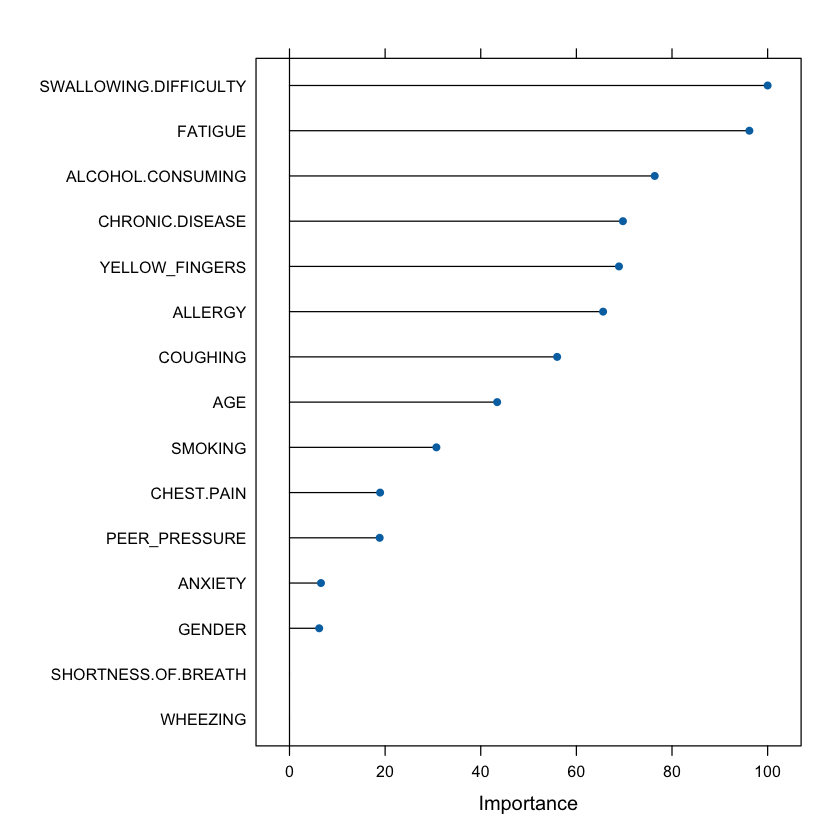

5-fold CV error is  0.1091592Training balanced accuracy:  0.8911073 
Testing balanced accuracy:  0.7813853 


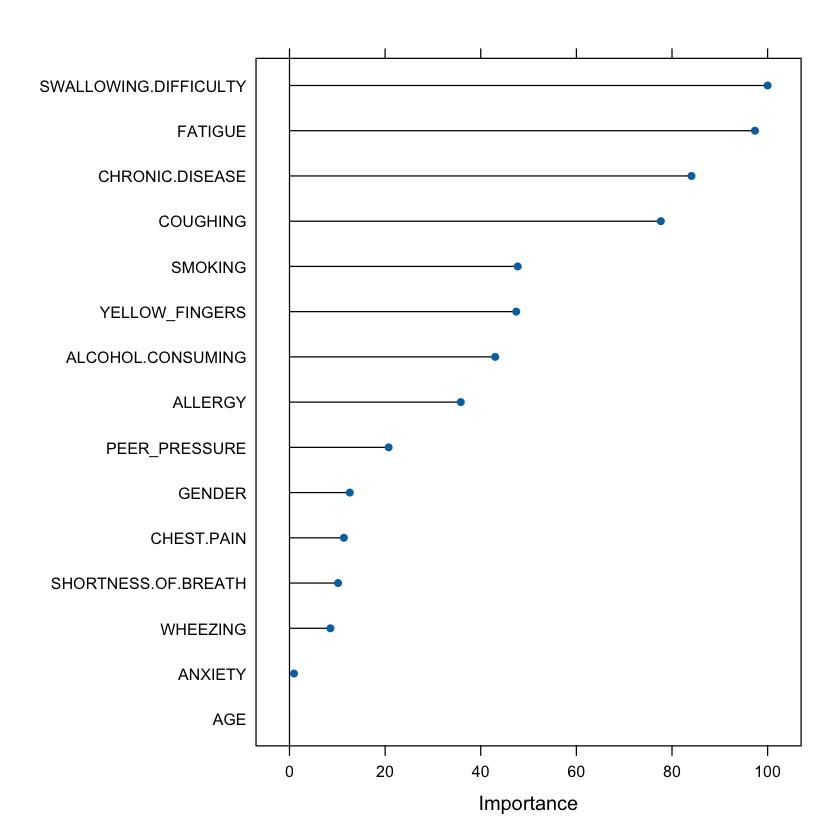

In [ ]:
library(caret)

# Prepare the dataset by recoding to {0, 1}; AGE remains same continuous;
# LUNG_CANCER remains as a factor
lung_cancer_LR <- lung_cancer %>%
  mutate(
    GENDER = ifelse(GENDER == "M", 1, 0),  # GENDER: 1 = Male, 0 = Female
    LUNG_CANCER = as.factor(LUNG_CANCER),
    SMOKING = ifelse(SMOKING == 2, 1, 0),        # Convert factor to binary: 1 = Yes, 0 = No
    YELLOW_FINGERS = ifelse(YELLOW_FINGERS == 2, 1, 0),
    ANXIETY = ifelse(ANXIETY == 2, 1, 0),
    PEER_PRESSURE = ifelse(PEER_PRESSURE == 2, 1, 0),
    CHRONIC.DISEASE = ifelse(CHRONIC.DISEASE == 2, 1, 0),
    FATIGUE = ifelse(FATIGUE == 2, 1, 0),
    ALLERGY = ifelse(ALLERGY == 2, 1, 0),
    WHEEZING = ifelse(WHEEZING == 2, 1, 0),
    ALCOHOL.CONSUMING = ifelse(ALCOHOL.CONSUMING == 2, 1, 0),
    COUGHING = ifelse(COUGHING == 2, 1, 0),
    SHORTNESS.OF.BREATH = ifelse(SHORTNESS.OF.BREATH == 2, 1, 0),
    SWALLOWING.DIFFICULTY = ifelse(SWALLOWING.DIFFICULTY == 2, 1, 0),
    CHEST.PAIN = ifelse(CHEST.PAIN == 2, 1, 0)
  )

# Split data before any transformation
set.seed(1547)
# Create indicies & SPLIT
indicies <- runif(nrow(lung_cancer_LR)) <= 0.7
train_data <- lung_cancer_LR %>% filter(indicies)
test_data <- lung_cancer_LR %>% filter(!indicies)

mod_log <- caret::train(LUNG_CANCER ~ .,
                 data = train_data,
                 method = 'glm',
                 family = binomial,
                 trControl = trainControl(method = 'cv', number = 5))
coef(mod_log$finalModel)

# 5-fold cross-validation error rate
cat("5-fold CV error is ", 1 - mod_log$results$Accuracy, "\n")

# balanced accuracy

CM <- mod_log %>% predict(train_data) %>%
  confusionMatrix(as.factor(train_data$LUNG_CANCER))

cat("Training balanced accuracy: ", CM$byClass['Balanced Accuracy'], "\n")


CM <- mod_log %>% predict(test_data) %>%
  confusionMatrix(as.factor(test_data$LUNG_CANCER))

cat("Testing balanced accuracy: ", CM$byClass['Balanced Accuracy'], "\n")


lambda_value = 10^seq(-2, 0, length = 20)
lasso_var <- caret::train(LUNG_CANCER ~., data = train_data, method = "glmnet",
                   trControl = trainControl("cv", number = 5),
                   tuneGrid = expand.grid(alpha = 1, lambda = lambda_value),
                   preProcess = c("scale")
)

# get coefficients of selected models
# coef(lasso_var$finalModel, lasso_var$bestTune$lambda)
plot(varImp(lasso_var, scale=TRUE))

# get coefficients of selected models
coef_df <- as.data.frame(as.matrix(coef(lasso_var$finalModel, lasso_var$bestTune$lambda)))
lasso_selected_features <- rownames(coef_df)[coef_df[ ,1] != 0]
lasso_selected_features <- lasso_selected_features[lasso_selected_features != "(LUNG_CANCER)"]

# feature names cleaning by removing numbers/char generated by elastic net, also rename intercept
removed_lasso_feature_names <- gsub("\\d+", "", lasso_selected_features)
cleaned_lasso_feature_names <- gsub("GENDERM", "GENDER", removed_lasso_feature_names)
cleaned_lasso_feature_names[cleaned_lasso_feature_names == "(Intercept)"] <- "LUNG_CANCER"


# plot coefficients of the LASSO model except for the intercept
lambda_for_plotting <- 10^seq(from = -2, to = 2, length = 100)
lasso_coefs <- coef(lasso_var$finalModel, lambda_for_plotting) %>%
  as.matrix %>% t %>% as_tibble %>%
  mutate(lambda = lambda_for_plotting)

# train elastic net using best lambda obtained
best_lasso <- caret::train(LUNG_CANCER ~., data = train_data, method = "glmnet",
                    trControl = trainControl("cv", number = 5),
                    tuneGrid = expand.grid(alpha = 1, lambda = lasso_var$bestTune$lambda),
                    preProcess = c("scale")
)

# train logistic regression using selected features
lasso_test <- test_data
lasso_train <- train_data

lasso_train <- lasso_train%>%
  select(all_of(cleaned_lasso_feature_names))
lasso_test <- lasso_test %>%
  select(all_of(cleaned_lasso_feature_names))

lasso_mod_log <- caret::train(LUNG_CANCER ~ .,
                 data = lasso_train,
                 method = 'glm',
                 family = binomial,
                 trControl = trainControl(method = 'cv', number = 5))

# 5-fold cross-validation error rate
cat("5-fold CV error is ", 1 - lasso_mod_log$results$Accuracy)

# balanced accuracy for train data
lasso_CM <- lasso_mod_log %>% predict(lasso_train) %>%
  confusionMatrix(as.factor(lasso_train$LUNG_CANCER))

cat("Training balanced accuracy: ", lasso_CM$byClass['Balanced Accuracy'], "\n")


# balanced accuracy for test data
lasso_CM <- lasso_mod_log %>% predict(lasso_test) %>%
  confusionMatrix(as.factor(lasso_test$LUNG_CANCER))

cat("Testing balanced accuracy: ", lasso_CM$byClass['Balanced Accuracy'], "\n")


elastic_net <- caret::train(
  LUNG_CANCER ~., data = train_data, method = "glmnet",
  trControl = trainControl("cv", number = 5)
)

# get coefficients of selected models
coef(elastic_net$finalModel, s = elastic_net$bestTune$lambda)
elastic_coef_df <- as.data.frame(as.matrix(coef(elastic_net$finalModel, s = elastic_net$bestTune$lambda)))
elastic_selected_features <- rownames(elastic_coef_df)[elastic_coef_df[ ,1] != 0]
elastic_selected_features <- elastic_selected_features[elastic_selected_features != "(LUNG_CANCER)"]

# feature names cleaning by removing numbers/char generated by elastic net, also rename intercept
removed_elastic_feature_names <- gsub("\\d+", "", elastic_selected_features)
cleaned_elastic_feature_names <- gsub("GENDERM", "GENDER", removed_elastic_feature_names)
cleaned_elastic_feature_names[cleaned_elastic_feature_names == "(Intercept)"] <- "LUNG_CANCER"

# plot their importance
plot(varImp(elastic_net, scale=TRUE))

# train elastic net using best alpha and best lambda obtained
best_elastic_net <- caret::train(LUNG_CANCER ~.,
                          data = train_data,
                          method = "glmnet",
                          tuneGrid = expand.grid(alpha = elastic_net$bestTune$alpha,
                                                 lambda = elastic_net$bestTune$lambda),
                          trControl = trainControl("cv", number = 5)
)

# train logistic regression using selected features
elastic_test <- test_data
elastic_train <- train_data

elastic_train <- elastic_train%>%
  select(all_of(cleaned_elastic_feature_names))
elastic_test <- elastic_test %>%
  select(all_of(cleaned_elastic_feature_names))


elastic_mod_log <- caret::train(LUNG_CANCER ~ .,
                 data = elastic_train,
                 method = 'glm',
                 family = binomial,
                 trControl = trainControl(method = 'cv', number = 5))

# 5-fold cross-validation error rate
cat("5-fold CV error is ", 1 - elastic_mod_log$results$Accuracy)

# balanced accuracy for train data
elastic_CM <- elastic_mod_log %>% predict(elastic_train) %>%
  confusionMatrix(as.factor(elastic_train$LUNG_CANCER))

cat("Training balanced accuracy: ", elastic_CM$byClass['Balanced Accuracy'], "\n")


# balanced accuracy for test data
elastic_CM <- elastic_mod_log %>% predict(elastic_test) %>%
  confusionMatrix(as.factor(elastic_test$LUNG_CANCER))

cat("Testing balanced accuracy: ", elastic_CM$byClass['Balanced Accuracy'], "\n")


## Appendix 13.2.5

Deep Forest Code


In [ ]:
# Install packages
use_python_version('3.9.19')
# system("pip install numpy==1.26.4 pandas")
# system("pip install deep-forest")
# system("pip install scikit-learn==1.2.2")
# py_config()

# Import Library
train_test_split <- import('sklearn.model_selection')$train_test_split
balanced_accuracy_score <- import('sklearn.metrics')$balanced_accuracy_score
recall_score <- import('sklearn.metrics')$recall_score
LabelEncoder <- import("sklearn.preprocessing")$LabelEncoder
cross_val_score <- import("sklearn.model_selection")$cross_val_score
np <- import("numpy")
pd <- import("pandas")
sklearn <- import("sklearn")
gcforest <- import("deepforest")$CascadeForestClassifier
f1_score <- sklearn$metrics$f1_score
np$int <- np$int32
np$float <- np$float64
np$bool = np$bool_

# Transform dataset into Numpy with ROSE
train_indices <- createDataPartition(lung_cancer$LUNG_CANCER, p = 0.7, list = FALSE)
train_data <- lung_cancer[train_indices, ]
test_data <- lung_cancer[-train_indices, ]

train_data_rose <- ROSE(LUNG_CANCER ~ ., data = train_data, seed = 1547)$data
test_data_rose <- ROSE(LUNG_CANCER ~ ., data = test_data, seed = 1547)$data

np_train <- pd$DataFrame(train_data_rose)
np_test <- pd$DataFrame(test_data_rose)

label_encoder <- LabelEncoder()

np_train$GENDER <- label_encoder$fit_transform(np_train$GENDER)
np_test$GENDER <- label_encoder$fit_transform(np_test$GENDER)
np_train$LUNG_CANCER <- label_encoder$fit_transform(np_train$LUNG_CANCER)
np_test$LUNG_CANCER <- label_encoder$fit_transform(np_test$LUNG_CANCER)
np_train$SMOKING <- label_encoder$fit_transform(np_train$SMOKING)
np_test$SMOKING <- label_encoder$fit_transform(np_test$SMOKING)
np_train$YELLOW_FINGERS <- label_encoder$fit_transform(np_train$YELLOW_FINGERS)
np_test$YELLOW_FINGERS <- label_encoder$fit_transform(np_test$YELLOW_FINGERS)
np_train$ANXIETY <- label_encoder$fit_transform(np_train$ANXIETY)
np_test$ANXIETY <- label_encoder$fit_transform(np_test$ANXIETY)
np_train$PEER_PRESSURE <- label_encoder$fit_transform(np_train$PEER_PRESSURE)
np_test$PEER_PRESSURE <- label_encoder$fit_transform(np_test$PEER_PRESSURE)
np_train$CHRONIC.DISEASE <- label_encoder$fit_transform(np_train$CHRONIC.DISEASE)
np_test$CHRONIC.DISEASE <- label_encoder$fit_transform(np_test$CHRONIC.DISEASE)
np_train$FATIGUE <- label_encoder$fit_transform(np_train$FATIGUE)
np_test$FATIGUE <- label_encoder$fit_transform(np_test$FATIGUE)
np_train$ALLERGY <- label_encoder$fit_transform(np_train$ALLERGY)
np_test$ALLERGY <- label_encoder$fit_transform(np_test$ALLERGY)
np_train$WHEEZING <- label_encoder$fit_transform(np_train$WHEEZING)
np_test$WHEEZING <- label_encoder$fit_transform(np_test$WHEEZING)
np_train$ALCOHOL.CONSUMING <- label_encoder$fit_transform(np_train$ALCOHOL.CONSUMING)
np_test$ALCOHOL.CONSUMING <- label_encoder$fit_transform(np_test$ALCOHOL.CONSUMING)
np_train$COUGHING <- label_encoder$fit_transform(np_train$COUGHING)
np_test$COUGHING <- label_encoder$fit_transform(np_test$COUGHING)
np_train$SHORTNESS.OF.BREATH <- label_encoder$fit_transform(np_train$SHORTNESS.OF.BREATH)
np_test$SHORTNESS.OF.BREATH <- label_encoder$fit_transform(np_test$SHORTNESS.OF.BREATH)
np_train$SWALLOWING.DIFFICULTY <- label_encoder$fit_transform(np_train$SWALLOWING.DIFFICULTY)
np_test$SWALLOWING.DIFFICULTY <- label_encoder$fit_transform(np_test$SWALLOWING.DIFFICULTY)
np_train$CHEST.PAIN <- label_encoder$fit_transform(np_train$CHEST.PAIN)
np_test$CHEST.PAIN <- label_encoder$fit_transform(np_test$CHEST.PAIN)


X_train_np <- np_train[, !(names(np_train) %in% c("LUNG_CANCER"))]
y_train_np <- np_train[, "LUNG_CANCER"]

X_test_np <- np_test[, !(names(np_test) %in% c("LUNG_CANCER"))]
y_test_np <- np_test[, "LUNG_CANCER"]


# Hyperparameter tuning code
param_grid <- expand.grid(
  n_estimators = c(3L, 4L, 5L, 6L, 7L, 8L, 9L, 10L, 11L, 12L, 13L, 14L, 15L),
  n_trees = c('auto'),
  max_layers = c(1L, 2L, 3L)
)

# # Hyperparameter tuning with LightGBM
# result_lightgbm <- apply(param_grid, 1, function(params) {

#   params_list <- as.list(params)
#   model <- gcforest(n_estimators = as.integer(params_list$n_estimators), n_trees = 'auto', max_layers = as.integer(params_list$max_layers), predictor= 'lightgbm', use_predictor = TRUE)
#   cv_results <- cross_val_score(model, X_train_np, y_train_np, scoring = 'recall', error_score = 'raise', cv = 5L)
#   cv <- mean(cv_results)

#   return(list(cv = cv, params = params_list))
# })

# results_df_lightgbm <- data.frame(
#   cv = sapply(result_lightgbm, function(x) x$cv),
#   param_combination = sapply(result_lightgbm, function(x) {
#     paste0("n_estimators=", x$params$n_estimators,
#            ", n_trees=", x$params$n_trees,
#            ", max_layers=", x$params$max_layers)
#   })
# )

# ggplot(results_df_lightgbm, aes(x = param_combination, y = cv, group = 1)) +
#   geom_point(color = "blue", size = 4) +
#   geom_line(color = "red", linetype = "dashed") +
#   labs(title = "Average CV Score vs Parameter Combinations using LightGBM",
#        x = "Parameter Combinations", y = "Avg CV Score") +
#   theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
#   theme_minimal()

# best_result_lightgbm <- results_df_lightgbm[which.max(results_df_lightgbm$cv), ]

# cat("Best result with maximum CV score with LightGBM:", best_result_lightgbm$cv, "\n")
# print(best_result_lightgbm$param_combination)

# # Hyperparameter tuning with XGBoost
# results_xgboost <- apply(param_grid, 1, function(params) {

#   params_list <- as.list(params)
#   model <- gcforest(n_estimators = as.integer(params_list$n_estimators), n_trees = 'auto', max_layers = as.integer(params_list$max_layers), predictor= "xgboost", use_predictor = TRUE)
#   cv_results <- cross_val_score(model, X_train_np, y_train_np, scoring = 'recall', error_score = 'raise', cv = 5L)
#   cv <- mean(cv_results)

#   return(list(cv = cv, params = params_list))
# })



# results_df_xgboost <- data.frame(
#   cv = sapply(results_xgboost, function(x) x$cv),
#   param_combination = sapply(results_xgboost, function(x) {
#     paste0("n_estimators=", x$params$n_estimators,
#            ", n_trees=", x$params$n_trees,
#            ", max_layers=", x$params$max_layers)
#   })
# )


# ggplot(results_df_xgboost, aes(x = param_combination, y = cv, group = 1)) +
#   geom_point(color = "blue", size = 4) +
#   geom_line(color = "red", linetype = "dashed") +
#   labs(title = "Average CV Score vs Parameter Combinations using XGBoost",
#        x = "Parameter Combinations", y = "Avg CV Score") +
#   theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
#   theme_minimal()



# best_result_xgboost <- results_df_xgboost[which.max(results_df_xgboost$cv), ]

# cat("Best result with maximum CV score with XGBoost:", best_result_xgboost$cv, "\n")
# print(best_result_xgboost$param_combination)

# # Best Model with tuned hyperparameter
# best_model <- gcforest(n_estimators = 8L, n_trees = 'auto', max_layers = 2L, predictor= "xgboost")

# best_model$fit(X_train_np, y_train_np)

# y_pred_train_raw <- best_model$predict_proba(X_train_np)
# y_pred_train <- ifelse(y_pred_train_raw[,2] > 0.1, 1, 0)

# train_accuracy <- accuracy_score(y_train_np, y_pred_train) * 100
# cat(sprintf("Training Accuracy: %.3f %%\n", train_accuracy))


# y_pred_test_raw <- best_model$predict_proba(X_test_np)
# y_pred_test <- ifelse(y_pred_test_raw[,2] > 0.1, 1, 0)

# test_acc <- accuracy_score(y_test_np, y_pred_test) * 100
# cat(sprintf("\nTesting Accuracy: %.3f %%\n", test_acc))
# f1_test <- f1_score(y_test_np, y_pred_test, average = 'binary')
# cat(sprintf("\nTesting F1 Score: %.3f \n", f1_test))


# y_test_factor <- as.factor(y_test_np)
# y_test_pred_factor <- as.factor(y_pred_test)
# levels(y_test_pred_factor) <- levels(y_test_factor)

# y_train_factor <- as.factor(y_train_np)
# y_train_pred_factor <- as.factor(y_pred_train)
# levels(y_train_pred_factor) <- levels(y_train_factor)

# test_confusion_matrix <- confusionMatrix(as.factor(y_pred_test),  as.factor(y_test_np))
# print(test_confusion_matrix)

# train_confusion_matrix <- confusionMatrix(as.factor(y_pred_train),  as.factor(y_train_np))
# train_confusion_matrix



## Appendix 13.2.6

Artificial Neural Network Model Code

In [ ]:
train_indices <- createDataPartition(lung_cancer$LUNG_CANCER, p = 0.7, list = FALSE)
train_data <- lung_cancer[train_indices, ]
test_data <- lung_cancer[-train_indices, ]

train_data_rose <- ROSE(LUNG_CANCER ~ ., data = train_data, seed = 1547)$data
train_data_rose <- train_data_rose %>% mutate(across(everything(), as.numeric))

balanced_test_data <- ROSE(LUNG_CANCER ~ ., data = test_data, seed = 1547)$data
balanced_test_data <- balanced_test_data %>% mutate(across(everything(), as.numeric))

print(table(train_data_rose$LUNG_CANCER))

binary_transform <- function(df) {
  df %>% mutate(across(everything(), ~ ifelse(. == 2, 1, 0)))
}

train_data_binary <- binary_transform(train_data_rose)
test_data_binary <- binary_transform(balanced_test_data)

x_train <- train_data_binary %>%
  select(-LUNG_CANCER) %>%
  as.matrix()

y_train <- as.numeric(train_data_binary$LUNG_CANCER)

x_test <- test_data_binary%>%
  select(-LUNG_CANCER) %>%
  as.matrix()

y_test <- as.numeric(test_data_binary$LUNG_CANCER)

# Updated ANN Model
model_1 <- keras_model_sequential() %>%
  layer_dense(units = 512, activation = 'relu', input_shape = c(ncol(x_train)),
              kernel_regularizer = regularizer_l2(0.01)) %>%
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.4) %>%
  layer_dense(units = 256, activation = 'relu', kernel_regularizer = regularizer_l2(0.01)) %>%
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.4) %>%
  layer_dense(units = 128, activation = 'relu', kernel_regularizer = regularizer_l2(0.01)) %>%
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.4) %>%
  layer_dense(units = 1, activation = 'sigmoid')

# Compile Model with Weighted Loss
model_1 %>% compile(
  loss = loss_binary_crossentropy(),
  optimizer = optimizer_adam(learning_rate = 0.0005),
  metrics = c(metric_binary_accuracy(), metric_recall())
)

# Adjusted Callbacks
callbacks <- list(
  callback_early_stopping(monitor = "val_recall", mode = "max", patience = 10, restore_best_weights = TRUE),
  callback_model_checkpoint(filepath = "best_model.keras", save_best_only = TRUE),
  callback_reduce_lr_on_plateau(monitor = "val_loss", factor = 0.3, patience = 5, min_lr = 1e-6)
)


# Adjusted Class Weights
class_weights <- list(
  "0" = 1,
  "1" = 5  # Increased weight for minority class
)

# Train Model
history_1 <- model_1 %>% fit(
  x = x_train,
  y = y_train,
  epochs = 100,
  batch_size = 32,
  validation_split = 0.2,
  callbacks = callbacks,
  class_weight = class_weights
)

# Predict and Evaluate
predictions_1 <- model_1 %>% predict(x_test)
predicted_classes <- ifelse(predictions_1 > 0.07, 1, 0)  # Adjust threshold
confusion_matrix_test <- table(Predicted = predicted_classes, Actual = y_test)

# Calculate Recall and Balanced Accuracy
train_predictions <- model_1 %>% predict(x_train)
train_predicted_classes <- ifelse(train_predictions > 0.07, 1, 0)
confusion_matrix_train <- table(Predicted = train_predicted_classes, Actual = y_train)

train_recall <- calculate_recall(confusion_matrix_train)
test_recall <- calculate_recall(confusion_matrix_test)

train_balanced_accuracy <- calculate_balanced_accuracy(confusion_matrix_train)
test_balanced_accuracy <- calculate_balanced_accuracy(confusion_matrix_test)

# Print Results
cat("Training Recall:", train_recall, "\n")
cat("Test Recall:", test_recall, "\n")
cat("Training Balanced Accuracy:", train_balanced_accuracy, "\n")
cat("Test Balanced Accuracy:", test_balanced_accuracy, "\n")

cat("\nTraining Confusion Matrix:\n")
print(confusion_matrix_train)

cat("\nTest Confusion Matrix:\n")
print(confusion_matrix_test)


## Appendix 13.2.7

Persistent Homology Model Code

In [ ]:
lung_cancer <- read.csv("survey lung cancer.csv", header = TRUE)
# Convert GENDER and LUNG_CANCER to numeric factors
lung_cancer$GENDER <- as.numeric(factor(lung_cancer$GENDER, levels = c("M", "F")))
lung_cancer$LUNG_CANCER <- as.numeric(factor(lung_cancer$LUNG_CANCER, levels = c("NO", "YES")))


# List of columns to convert to numeric
cols_to_convert <- c("GENDER", "SMOKING", "YELLOW_FINGERS",
                     "ANXIETY", "PEER_PRESSURE",
                     "CHRONIC.DISEASE", "FATIGUE",
                     "ALLERGY", "WHEEZING",
                     "ALCOHOL.CONSUMING", "COUGHING",
                     "SHORTNESS.OF.BREATH",
                     "SWALLOWING.DIFFICULTY",
                     "CHEST.PAIN", "LUNG_CANCER")

# Convert selected columns to numeric
lung_cancer[cols_to_convert] <- lapply(lung_cancer[cols_to_convert], as.numeric)







# Select binary columns for analysis; WITHOUT AGE
binary_data <- lung_cancer[, c("GENDER", "SMOKING",
                                "YELLOW_FINGERS", "ANXIETY",
                                "PEER_PRESSURE", "CHRONIC.DISEASE",
                                "FATIGUE", "ALLERGY", "WHEEZING",
                                "ALCOHOL.CONSUMING", "COUGHING",
                                "SHORTNESS.OF.BREATH",
                                "SWALLOWING.DIFFICULTY", "CHEST.PAIN",
                                "LUNG_CANCER")]



# Generate a Rips simplicial complex directly from binary data
rips_complex <- ripsDiag(binary_data, maxdimension = 1, maxscale = 2, printProgress = FALSE, dist = "euclidean")

# Access the simplices
simplices <- rips_complex$simplices


# Plot the data and simplices
plot(binary_data, main = "Point Cloud with Simplices")
points(binary_data[simplices[, 1], ], col = "red", pch = 16)


# Summary of the persistent homology
print(rips_complex)

# Plot rotated persistence diagram
plot(rips_complex[["diagram"]], main = "Rotated Persistence Diagram", rotated = TRUE)
# Add a simplified legend
legend("right",
       legend = c("= Connected Component",
                  "= Loop"),
       col = c("black", "red"),
       pch = c(16, 17),  # 16 is for point, 17 is for triangle
       bty = "o")  # Remove box around the legend


# Plot persistence diagram
plot(rips_complex[["diagram"]], main = "Persistence Diagram")
# Add a simplified legend
legend("right",
       legend = c("= Connected Component",
                  "= Loop"),
       col = c("black", "red"),
       pch = c(16, 17),  # 16 is for point, 17 is for triangle
       bty = "o")  # Remove box around the legend



# Plot barcode persistence diagram
plot(rips_complex[["diagram"]], main = "Persistence Diagram", barcode = TRUE)
# Plot 2 diagonal & horizontal line from youtube video
abline(0, 1, col = "blue", lwd = 1, lty = 2)

# Add a simplified legend
legend("topleft",
       legend = c("= Connected Component",
                  "= Loop"),
       col = c("black", "red"),
       pch = c(15, 15),  # 16 is for point, 17 is for triangle
       bty = "o")  # Remove box around the legend

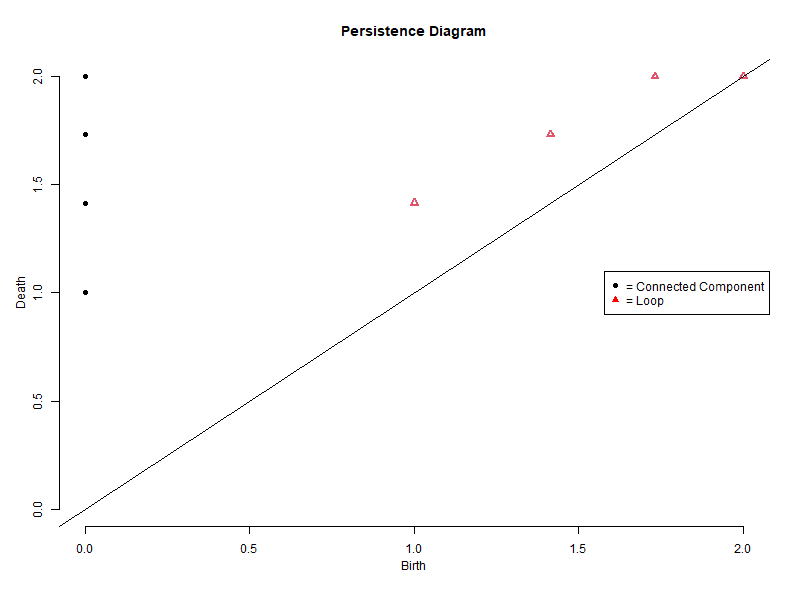